# East coast floods


In [1]:
import os
import datetime
import glob

from collections import Counter
import calendar
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy
import cartopy.crs as ccrs
import geopandas as gp
from IPython.display import Image
from scipy.stats import genextreme as gev
import xclim as xc
import cmocean
import seaborn as sns

from unseen import fileio
from unseen import general_utils
from unseen import time_utils
from unseen import stability

In [2]:
# Optional parameters 
# (This cell is tagged "parameters")
dpi = 300

In [3]:
# Parameters
agcd_file = "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_AGCD-CSIRO_r005_1900-2022_annual-aug-to-sep_east-coast-flood-region.zarr.zip"
model_file = "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_MIROC6-dcppA-hindcast_196011-201811_annual-aug-to-sep_east-coast-flood-region.zarr.zip"
model_add_bc_file = "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_MIROC6-dcppA-hindcast_196011-201811_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-additive.zarr.zip"
model_mulc_bc_file = "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_MIROC6-dcppA-hindcast_196011-201811_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip"
similarity_add_bc_file = "/g/data/xv83/dbi599/east-coast-rain/data/similarity-test_Rx15day_MIROC6-dcppA-hindcast_196011-201811_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-additive.zarr.zip"
similarity_mulc_bc_file = "/g/data/xv83/dbi599/east-coast-rain/data/similarity-test_Rx15day_MIROC6-dcppA-hindcast_196011-201811_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip"
similarity_raw_file = "/g/data/xv83/dbi599/east-coast-rain/data/similarity-test_Rx15day_MIROC6-dcppA-hindcast_196011-201811_annual-aug-to-sep_east-coast-flood-region_AGCD-CSIRO.zarr.zip"
independence_plot = "/g/data/xv83/dbi599/east-coast-rain/figures/independence-test_Rx15day_MIROC6-dcppA-hindcast_196011-201811_annual-aug-to-sep_east-coast-flood-region.png"
moments_raw_plot = "/g/data/xv83/dbi599/east-coast-rain/figures/moments-test_Rx15day_MIROC6-dcppA-hindcast_196011-201811_annual-aug-to-sep_east-coast-flood-region_AGCD-CSIRO.png"
moments_add_plot = "/g/data/xv83/dbi599/east-coast-rain/figures/moments-test_Rx15day_MIROC6-dcppA-hindcast_196011-201811_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-additive.png"
moments_mulc_plot = "/g/data/xv83/dbi599/east-coast-rain/figures/moments-test_Rx15day_MIROC6-dcppA-hindcast_196011-201811_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-multiplicative.png"
stability_plot_empirical = "/g/data/xv83/dbi599/east-coast-rain/figures/stability-test-empirical_Rx15day_MIROC6-dcppA-hindcast_196011-201811_annual-aug-to-sep_east-coast-flood-region.png"
stability_plot_gev = "/g/data/xv83/dbi599/east-coast-rain/figures/stability-test-gev_Rx15day_MIROC6-dcppA-hindcast_196011-201811_annual-aug-to-sep_east-coast-flood-region.png"
model_name = "MIROC6"
min_lead = 1
region_name = "east-coast-flood-region"
shape_file = "/g/data/xv83/dbi599/east-coast-rain/shapefiles/east-coast-flood.shp"
file_list = (
    "/home/599/dbi599/east-coast-rain/file_lists/MIROC6_dcppA-hindcast_pr_files.txt"
)
nino_file = "/g/data/xv83/dbi599/east-coast-rain/data/nino34-anomaly_MIROC6-dcppA-hindcast_196011-201811_base-196011-201811.nc"


In [4]:
# Required parameters
assert 'model_name' in locals(), "Must provide a model name"
assert 'region_name' in locals(), "Must provide a region name"
assert 'min_lead' in locals(), "Must provide a minimum lead time"
assert os.path.isfile(file_list), "Must provide the input model files list (papermill option -p file_list [filepath])"
assert os.path.isfile(shape_file), "Must provide the shapefile (papermill option -p shape_file [filepath])"
assert os.path.isfile(agcd_file), "Must provide an AGCD data file (papermill option -p agcd_file [filepath])"
assert os.path.isfile(model_file), "Must provide an model data file (papermill option -p model_file [filepath])"
assert os.path.isfile(model_add_bc_file), "Must provide a model additive bias corrected data file (papermill option -p model_add_bc_file [filepath])"
assert os.path.isfile(model_mulc_bc_file), "Must provide a model multiplicative bias corrected data file (papermill option -p model_mulc_bc_file [filepath])"
assert os.path.isfile(nino_file), "Must provide a model Nino 3.4 data file (papermill option -p nino_file [filepath])"
assert os.path.isfile(similarity_add_bc_file), "Must provide an additive bias corrected similarity test file (papermill option -p similarity_add_bias_file [filepath])"
assert os.path.isfile(similarity_mulc_bc_file), "Must provide an multiplicative bias corrected similarity test file (papermill option -p similarity_mulc_bias_file [filepath])"
assert os.path.isfile(similarity_raw_file), "Must provide an raw data similarity test file (papermill option -p similarity_raw_file [filepath])"
assert os.path.isfile(independence_plot), "Must provide an independence test plot (papermill option -p independence_plot [filepath])"
assert os.path.isfile(stability_plot_empirical), "Must provide an empirical stability test plot (papermill option -p stability_plot_empirical [filepath])"
assert os.path.isfile(stability_plot_gev), "Must provide a GEV stability test plot (papermill option -p stability_plot_gev [filepath])"
assert os.path.isfile(moments_add_plot), "Must provide a moments test plot for the additive bias corrected data (papermill option -p moments_add_plot [filepath])"
assert os.path.isfile(moments_mulc_plot), "Must provide a moments test plot for the multiplicative bias corrected data (papermill option -p moments_mulc_plot [filepath])"
assert os.path.isfile(moments_raw_plot), "Must provide a moments test plot for the raw data (papermill option -p moments_raw_plot [filepath])"


## Observations

In [5]:
agcd_ds = fileio.open_dataset(agcd_file)
agcd_ds = agcd_ds.dropna('time')

In [6]:
agcd_ds

<xarray.Dataset>
Dimensions:     (time: 122)
Coordinates:
    event_time  (time) <U28 dask.array<chunksize=(122,), meta=np.ndarray>
  * time        (time) object 1901-01-01 09:00:00 ... 2022-01-01 09:00:00
Data variables:
    pr          (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/33)
    CDI:                           Climate Data Interface version ?? (http://...
    CDO:                           Climate Data Operators version 1.7.0 (http...
    Conventions:                   CF-1.6
    acknowledgment:                The Australian Government, Bureau of Meteo...
    analysis_components:           total: the gridded accumulation of rainfall.
    bom-cmp-awap_version:          bom-cmp-awap-1.00-89.0.x86_64
    ...                            ...
    summary:                       The daily and monthly rainfall data repres...
    time_coverage_end:             1900-01-01T09:00:00
    time_coverage_start:           1899-12-31T09:00:00
    title:                         Interpolated Rain Gauge Precipitation
    url:                           http://www.bom.gov.au/climate/
    uuid:                          14333ae2-28fe-4cb6-9f00-677adc94f25e

In [7]:
years = agcd_ds['time'].dt.year.values
agcd_df = pd.DataFrame(index=years)
agcd_df['pr'] = agcd_ds['pr'].values

In [8]:
pr2022 = agcd_ds['pr'].values.max()
print(pr2022)

410.43057


## Model ensemble

### Region selection

In [9]:
with open(file_list) as f:
    all_files = f.read()
    first_file = all_files.split('\n', 1)[0]

In [10]:
first_file

'/g/data/oi10/replicas/CMIP6/DCPP/MIROC/MIROC6/dcppA-hindcast/s1960-r1i1p1f1/day/pr/gn/v20191217/pr_day_MIROC6_dcppA-hindcast_s1960-r1i1p1f1_gn_19601101-19691231.nc'

In [11]:
shapes = gp.read_file(shape_file)

In [12]:
isel_dict = {}
if model_name == 'CAFE':
    isel_dict['ensemble'] = 0
    metadata_file = '/home/599/dbi599/unseen/config/dataset_cafe_daily.yml'
else:
    metadata_file = None

In [13]:
region_ds = fileio.open_dataset(
    first_file,
    metadata_file=metadata_file,
    variables=['pr'],
    lat_bnds=[-40, -20],
    lon_bnds=[140, 160],
    shapefile=shape_file,
    shape_overlap=0.1,
    units={'pr': 'mm day-1'},
    isel=isel_dict,
)

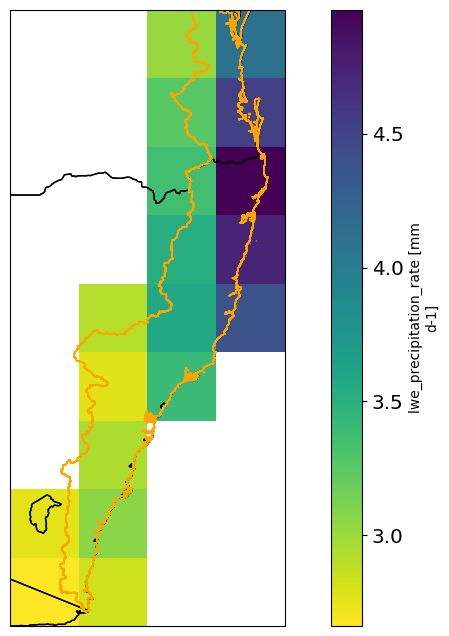

In [14]:
fig = plt.figure(figsize=[12,8])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
region_ds['pr'].mean('time', keep_attrs=True).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='viridis_r',
)
ax.coastlines()
ax.add_feature(cartopy.feature.STATES)
ax.add_geometries(shapes.geometry, ccrs.PlateCarree(), facecolor='none', edgecolor='orange')
plt.show()

### Model data

In [15]:
model_ds = fileio.open_dataset(model_file)
model_add_bc_ds = fileio.open_dataset(model_add_bc_file)
model_mulc_bc_ds = fileio.open_dataset(model_mulc_bc_file)

In [16]:
model_ds

<xarray.Dataset>
Dimensions:     (ensemble: 10, init_date: 59, lead_time: 11)
Coordinates:
  * ensemble    (ensemble) int64 0 1 2 3 4 5 6 7 8 9
    event_time  (init_date, ensemble, lead_time) <U28 dask.array<chunksize=(59, 10, 11), meta=np.ndarray>
  * init_date   (init_date) object 1960-11-01 00:00:00 ... 2018-11-01 00:00:00
  * lead_time   (lead_time) int64 0 1 2 3 4 5 6 7 8 9 10
    time        (lead_time, init_date) object dask.array<chunksize=(11, 59), meta=np.ndarray>
Data variables:
    pr          (init_date, ensemble, lead_time) float64 dask.array<chunksize=(1, 1, 11), meta=np.ndarray>
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            DCPP
    branch_method:          Branching from dcppA-assim, but atmospheric initi...
    branch_time_in_child:   0.0
    branch_time_in_parent:  3957.0
    cmor_version:           3.4.0
    ...                     ...
    table_id:               day
    table_info:             Creation Date:(22 July 2019) MD5:b4cefb4b6dbb146f...
    title:                  MIROC6 output prepared for CMIP6
    tracking_id:            hdl:21.14100/95da9468-c246-4aba-a9e3-9be21aa5772f
    variable_id:            pr
    variant_label:          r1i1p1f1

### Independence testing

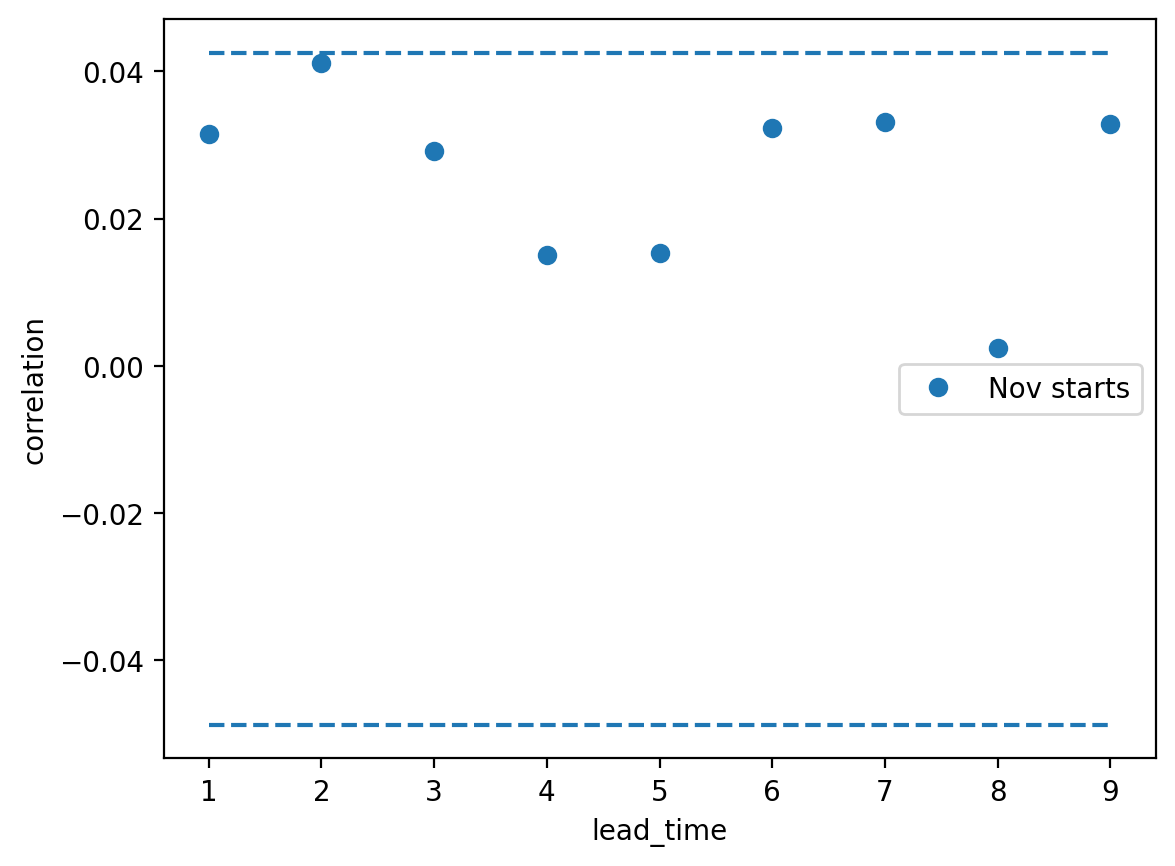

In [17]:
Image(filename=independence_plot)

In [18]:
print(min_lead)

1


In [19]:
model_da = model_ds['pr'].where(model_ds['lead_time'] >= min_lead)

In [20]:
model_da_stacked = model_da.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [21]:
model_da_stacked.shape

(5310,)

In [22]:
model_add_bc_da_stacked = model_add_bc_ds.dropna('lead_time')['pr'].stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [23]:
model_add_bc_da_stacked.shape

(5310,)

In [24]:
model_mulc_bc_da_stacked = model_mulc_bc_ds.dropna('lead_time')['pr'].stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [25]:
model_mulc_bc_da_stacked.shape

(5310,)

### Stability testing

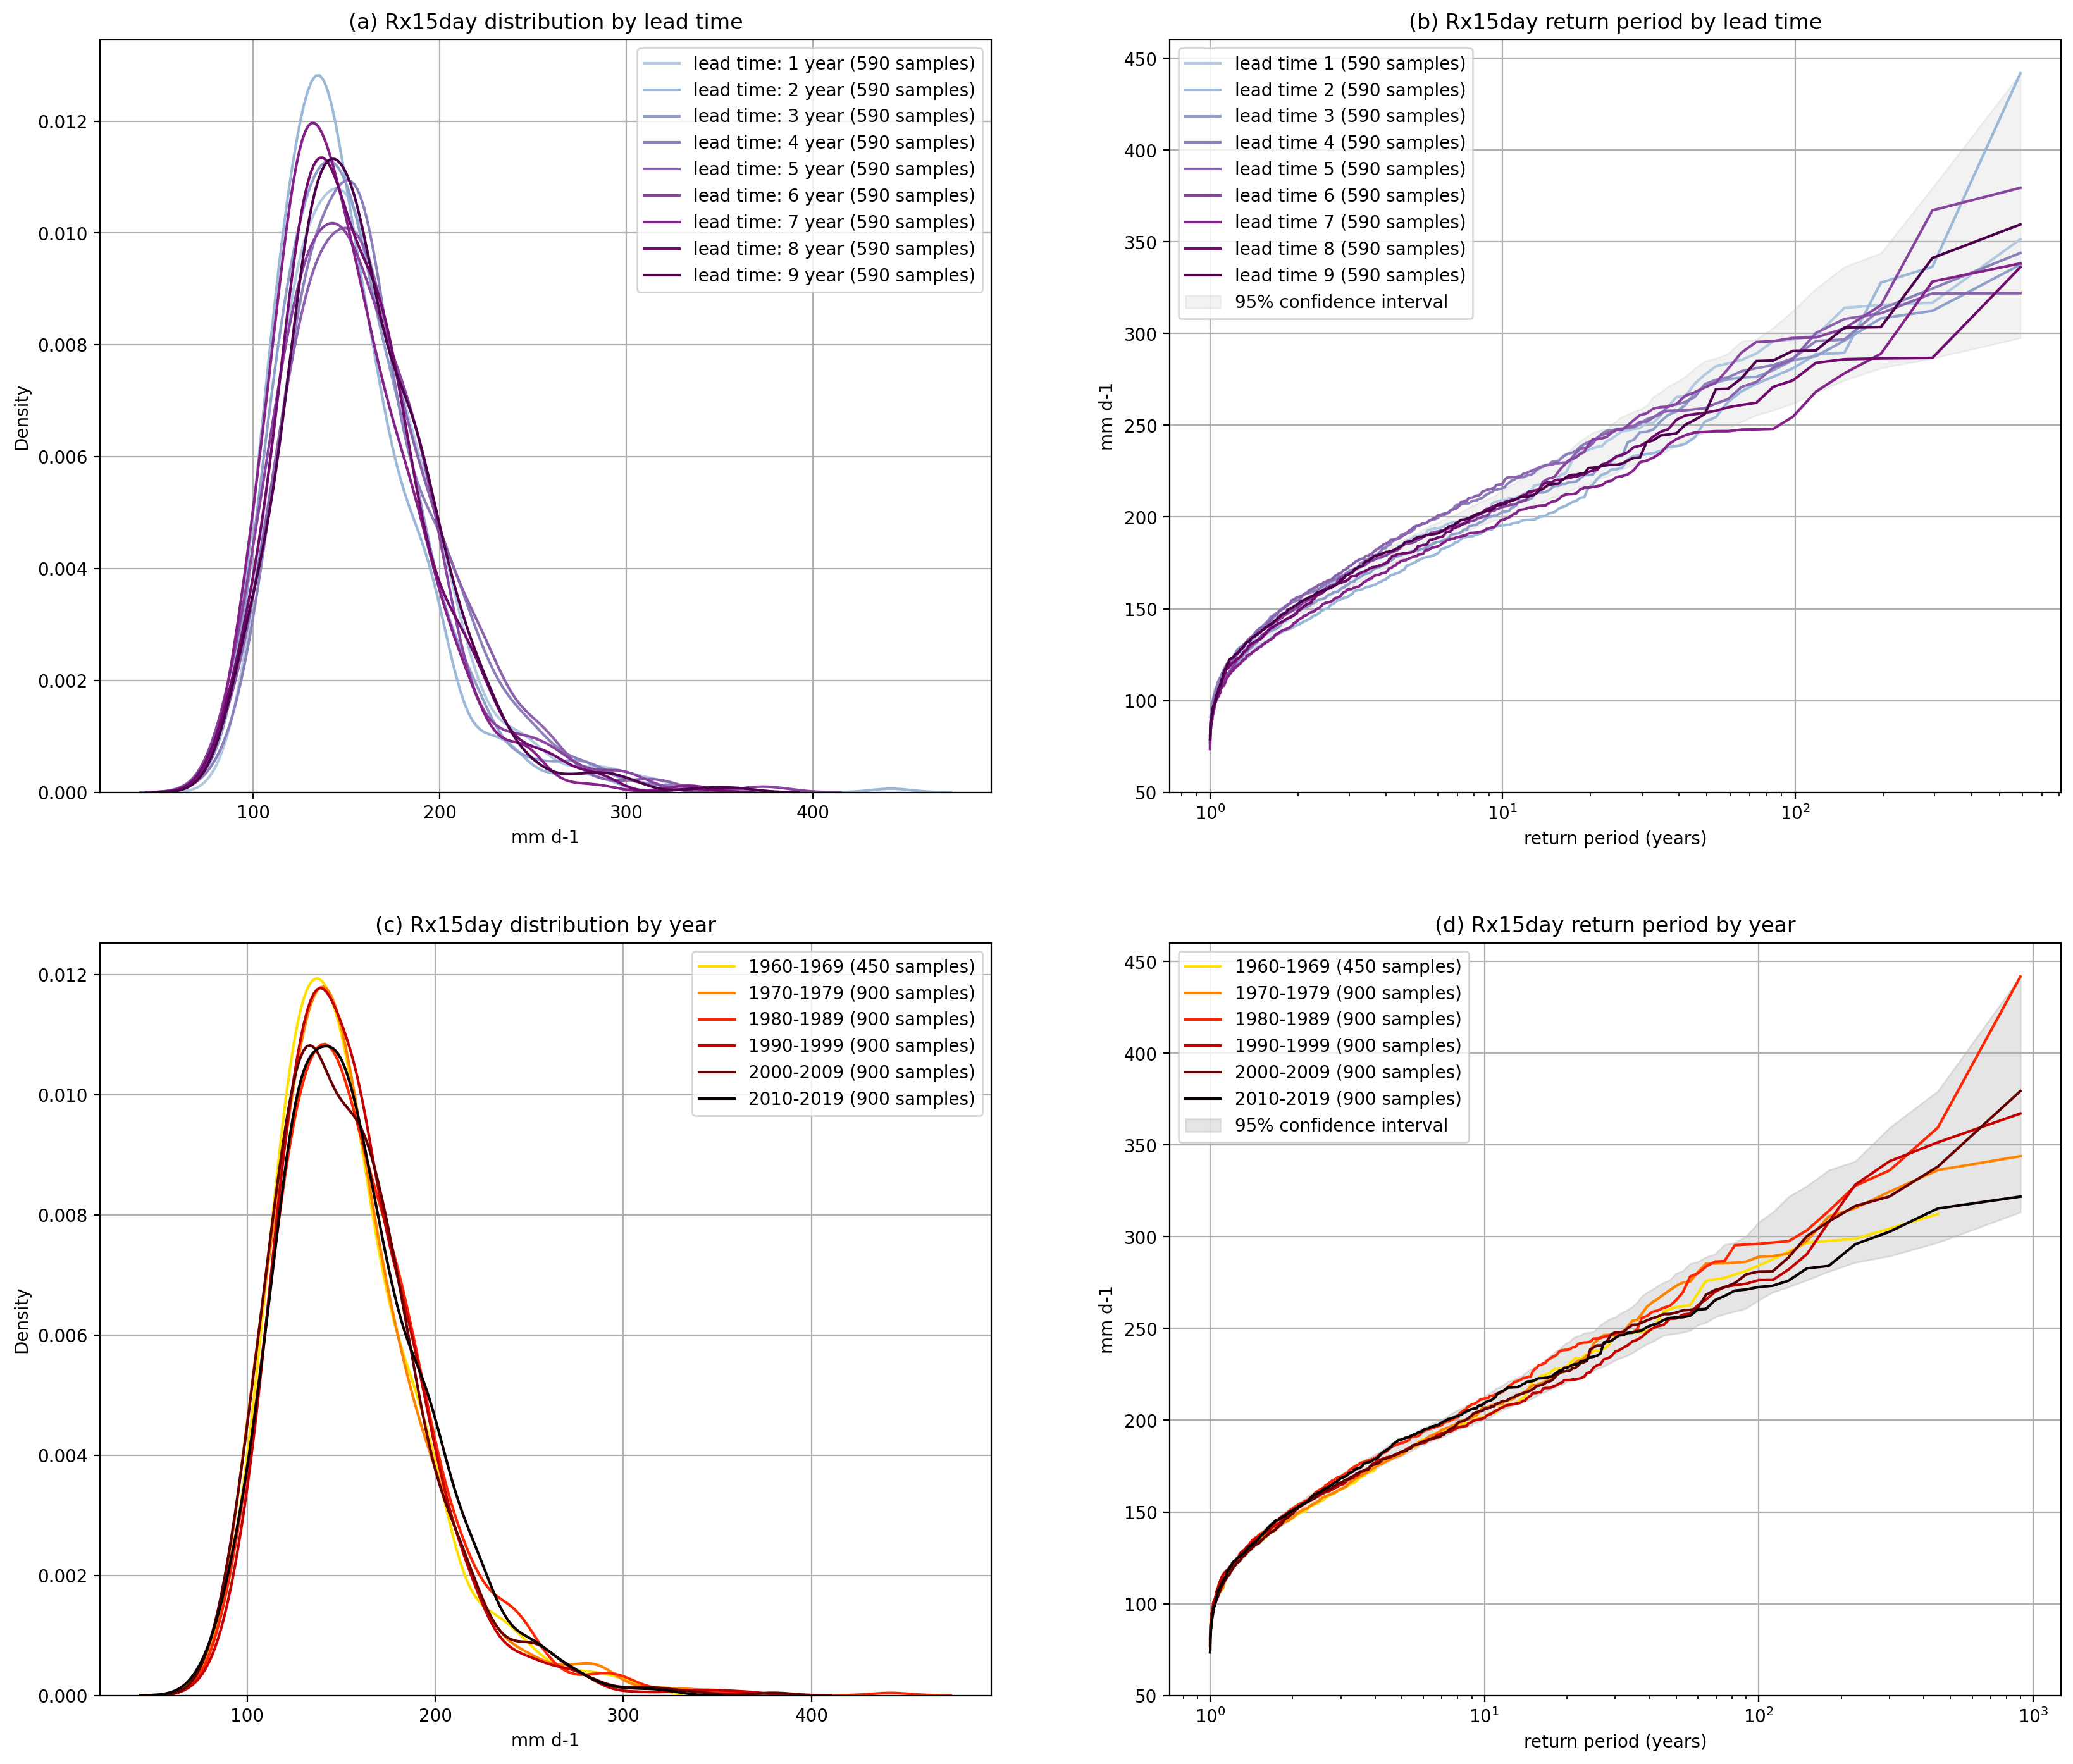

In [26]:
Image(filename=stability_plot_empirical)

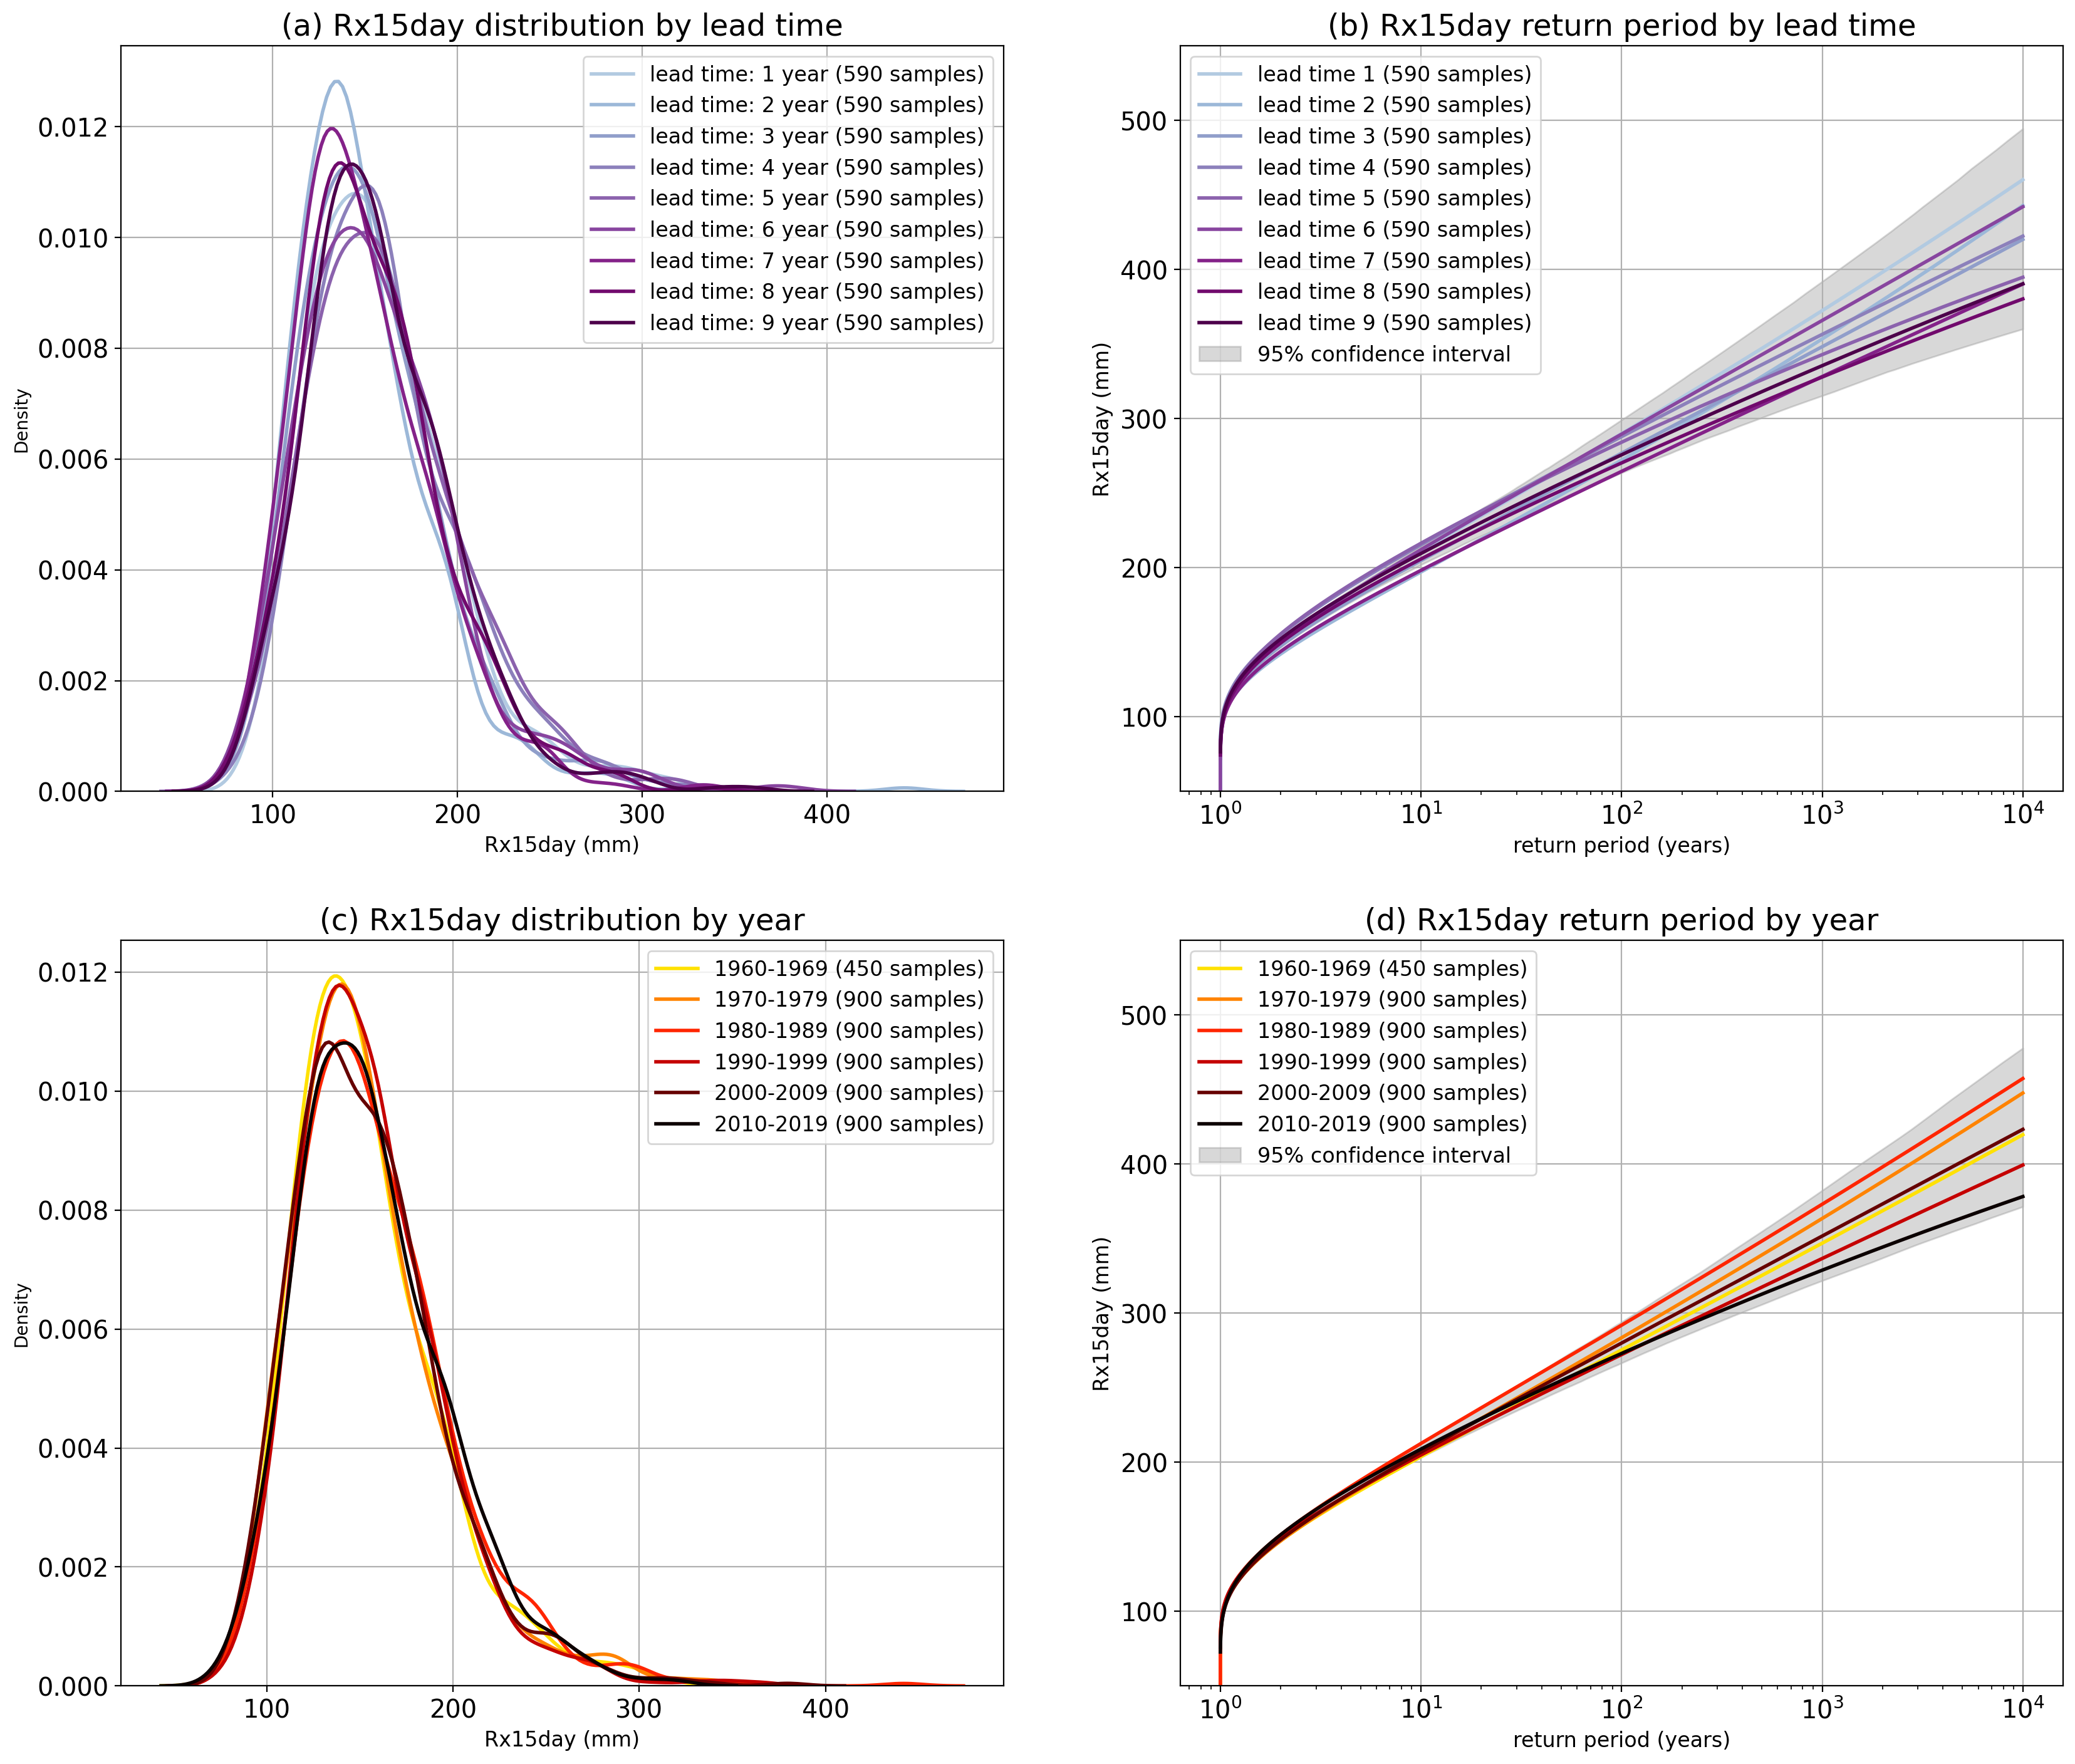

In [27]:
Image(filename=stability_plot_gev)

### Bias correction and similarity testing

In [28]:
model_gev_shape, model_gev_loc, model_gev_scale = general_utils.fit_gev(model_da_stacked.values)
model_add_bc_gev_shape, model_add_bc_gev_loc, model_add_bc_gev_scale = general_utils.fit_gev(model_add_bc_da_stacked.values)
model_mulc_bc_gev_shape, model_mulc_bc_gev_loc, model_mulc_bc_gev_scale = general_utils.fit_gev(model_mulc_bc_da_stacked.values)

In [29]:
def plot_distributions(include_additive=False):
    """Plot various distributions"""

    fig = plt.figure(figsize=[10, 6])
    gev_xvals = np.arange(0, 500)

    model_da.plot.hist(
        bins=50, density=True, label=model_name, alpha=0.7, facecolor='tab:blue',
    )
    model_gev_pdf = gev.pdf(gev_xvals, model_gev_shape, model_gev_loc, model_gev_scale)
    plt.plot(gev_xvals, model_gev_pdf, color='tab:blue', linewidth=4.0)

    if include_additive:
        model_add_bc_ds['pr'].plot.hist(
            bins=50, density=True, label=f'{model_name} additive bias corrected', facecolor='tab:red', alpha=0.7
        )
        model_add_bc_gev_pdf = gev.pdf(gev_xvals, model_add_bc_gev_shape, model_add_bc_gev_loc, model_add_bc_gev_scale)
        plt.plot(gev_xvals, model_add_bc_gev_pdf, color='tab:red', linewidth=4.0)

    model_mulc_bc_ds['pr'].plot.hist(
        bins=50, density=True, label=f'{model_name} multiplicative bias corrected', facecolor='tab:orange', alpha=0.7
    )
    model_mulc_bc_gev_pdf = gev.pdf(gev_xvals, model_mulc_bc_gev_shape, model_mulc_bc_gev_loc, model_mulc_bc_gev_scale)
    plt.plot(gev_xvals, model_mulc_bc_gev_pdf, color='tab:orange', linewidth=4.0)

    agcd_ds['pr'].plot.hist(
        bins=50, density=True, label='AGCD', facecolor='tab:gray', alpha=0.7
    )
    agcd_gev_shape, agcd_gev_loc, agcd_gev_scale = general_utils.fit_gev(agcd_ds['pr'].values)
    agcd_gev_pdf = gev.pdf(gev_xvals, agcd_gev_shape, agcd_gev_loc, agcd_gev_scale)
    plt.plot(gev_xvals, agcd_gev_pdf, color='tab:gray', linewidth=4.0)

    plt.xlabel('precipitation (mm)')
    plt.ylabel('probability')
    plt.title(f'Annual (Sep-Aug) Rx15day for {region_name} ({model_name})')
    plt.xlim(0, 500)
    plt.legend()
    if not include_additive:
        outfile = f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_histogram_{model_name}_{region_name}.png'
        print(outfile)
        plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
    plt.show()

/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_histogram_MIROC6_east-coast-flood-region.png


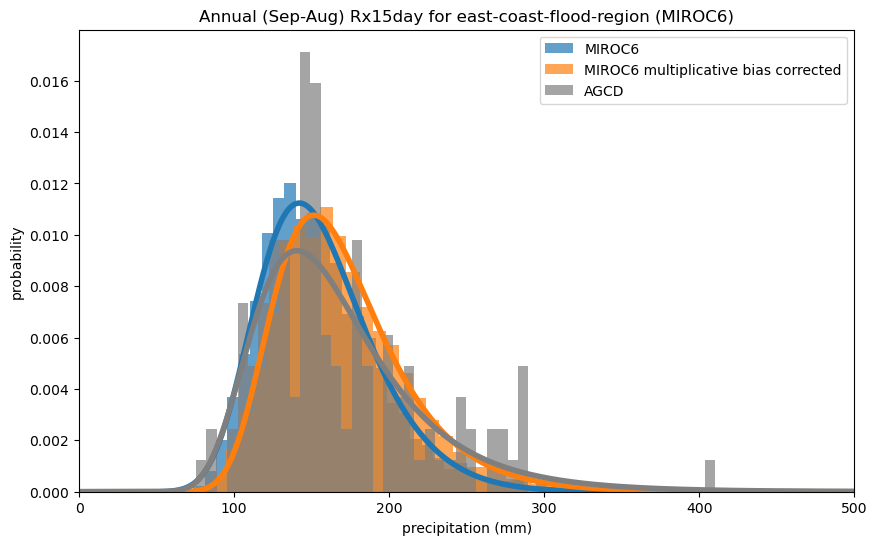

In [30]:
plot_distributions()

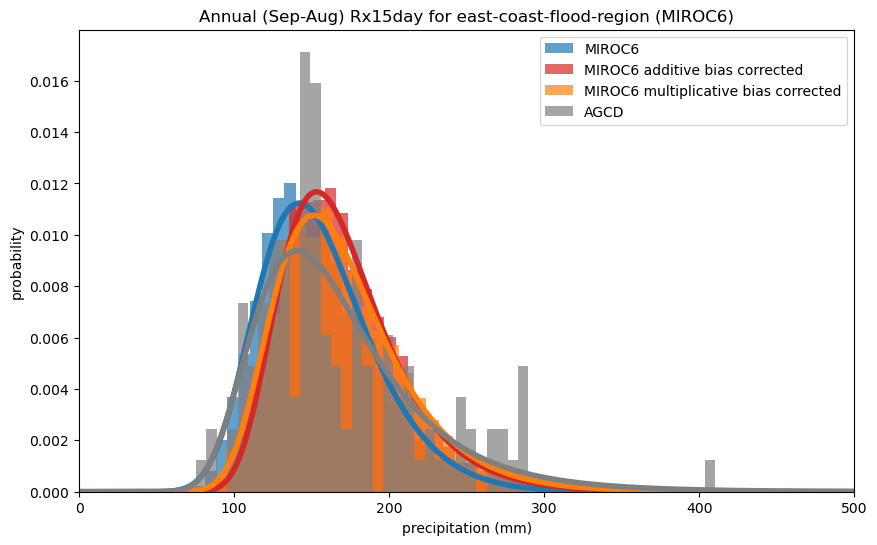

In [31]:
plot_distributions(include_additive=True)

In [32]:
print(f'raw data shape parameter: {model_gev_shape:.3f}')
print(f'raw data location parameter: {model_gev_loc:.3f}') 
print(f'raw data scale parameter: {model_gev_scale:.3f}')

raw data shape parameter: 0.087
raw data location parameter: 139.068
raw data scale parameter: 32.865


In [33]:
print(f'additive corrected shape parameter: {model_add_bc_gev_shape:.3f}')
print(f'additive corrected location parameter: {model_add_bc_gev_loc:.3f}') 
print(f'additive corrected scale parameter: {model_add_bc_gev_scale:.3f}')

additive corrected shape parameter: 0.015
additive corrected location parameter: 152.692
additive corrected scale parameter: 31.514


In [34]:
print(f'multiplicative corrected shape parameter: {model_mulc_bc_gev_shape:.3f}')
print(f'multiplicative corrected location parameter: {model_mulc_bc_gev_loc:.3f}') 
print(f'multiplicative corrected scale parameter: {model_mulc_bc_gev_scale:.3f}')

multiplicative corrected shape parameter: 0.010
multiplicative corrected location parameter: 151.042
multiplicative corrected scale parameter: 34.178


We can look at p-values for the KS-test and Anderson-Darling test for each lead time.

p > 0.05 means the null hypothesis (that the two samples are from the same population) can't be rejected.

In [35]:
similarity_raw_ds = fileio.open_dataset(similarity_raw_file)

In [36]:
similarity_raw_ds['ks_statistic'].values

array(0.17419963, dtype=float32)

In [37]:
similarity_raw_ds['ks_pval'].values

array(0.05115353, dtype=float32)

In [38]:
similarity_raw_ds['ad_statistic'].values

array(2.632963, dtype=float32)

In [39]:
similarity_raw_ds['ad_pval'].values

array(0.02715388, dtype=float32)

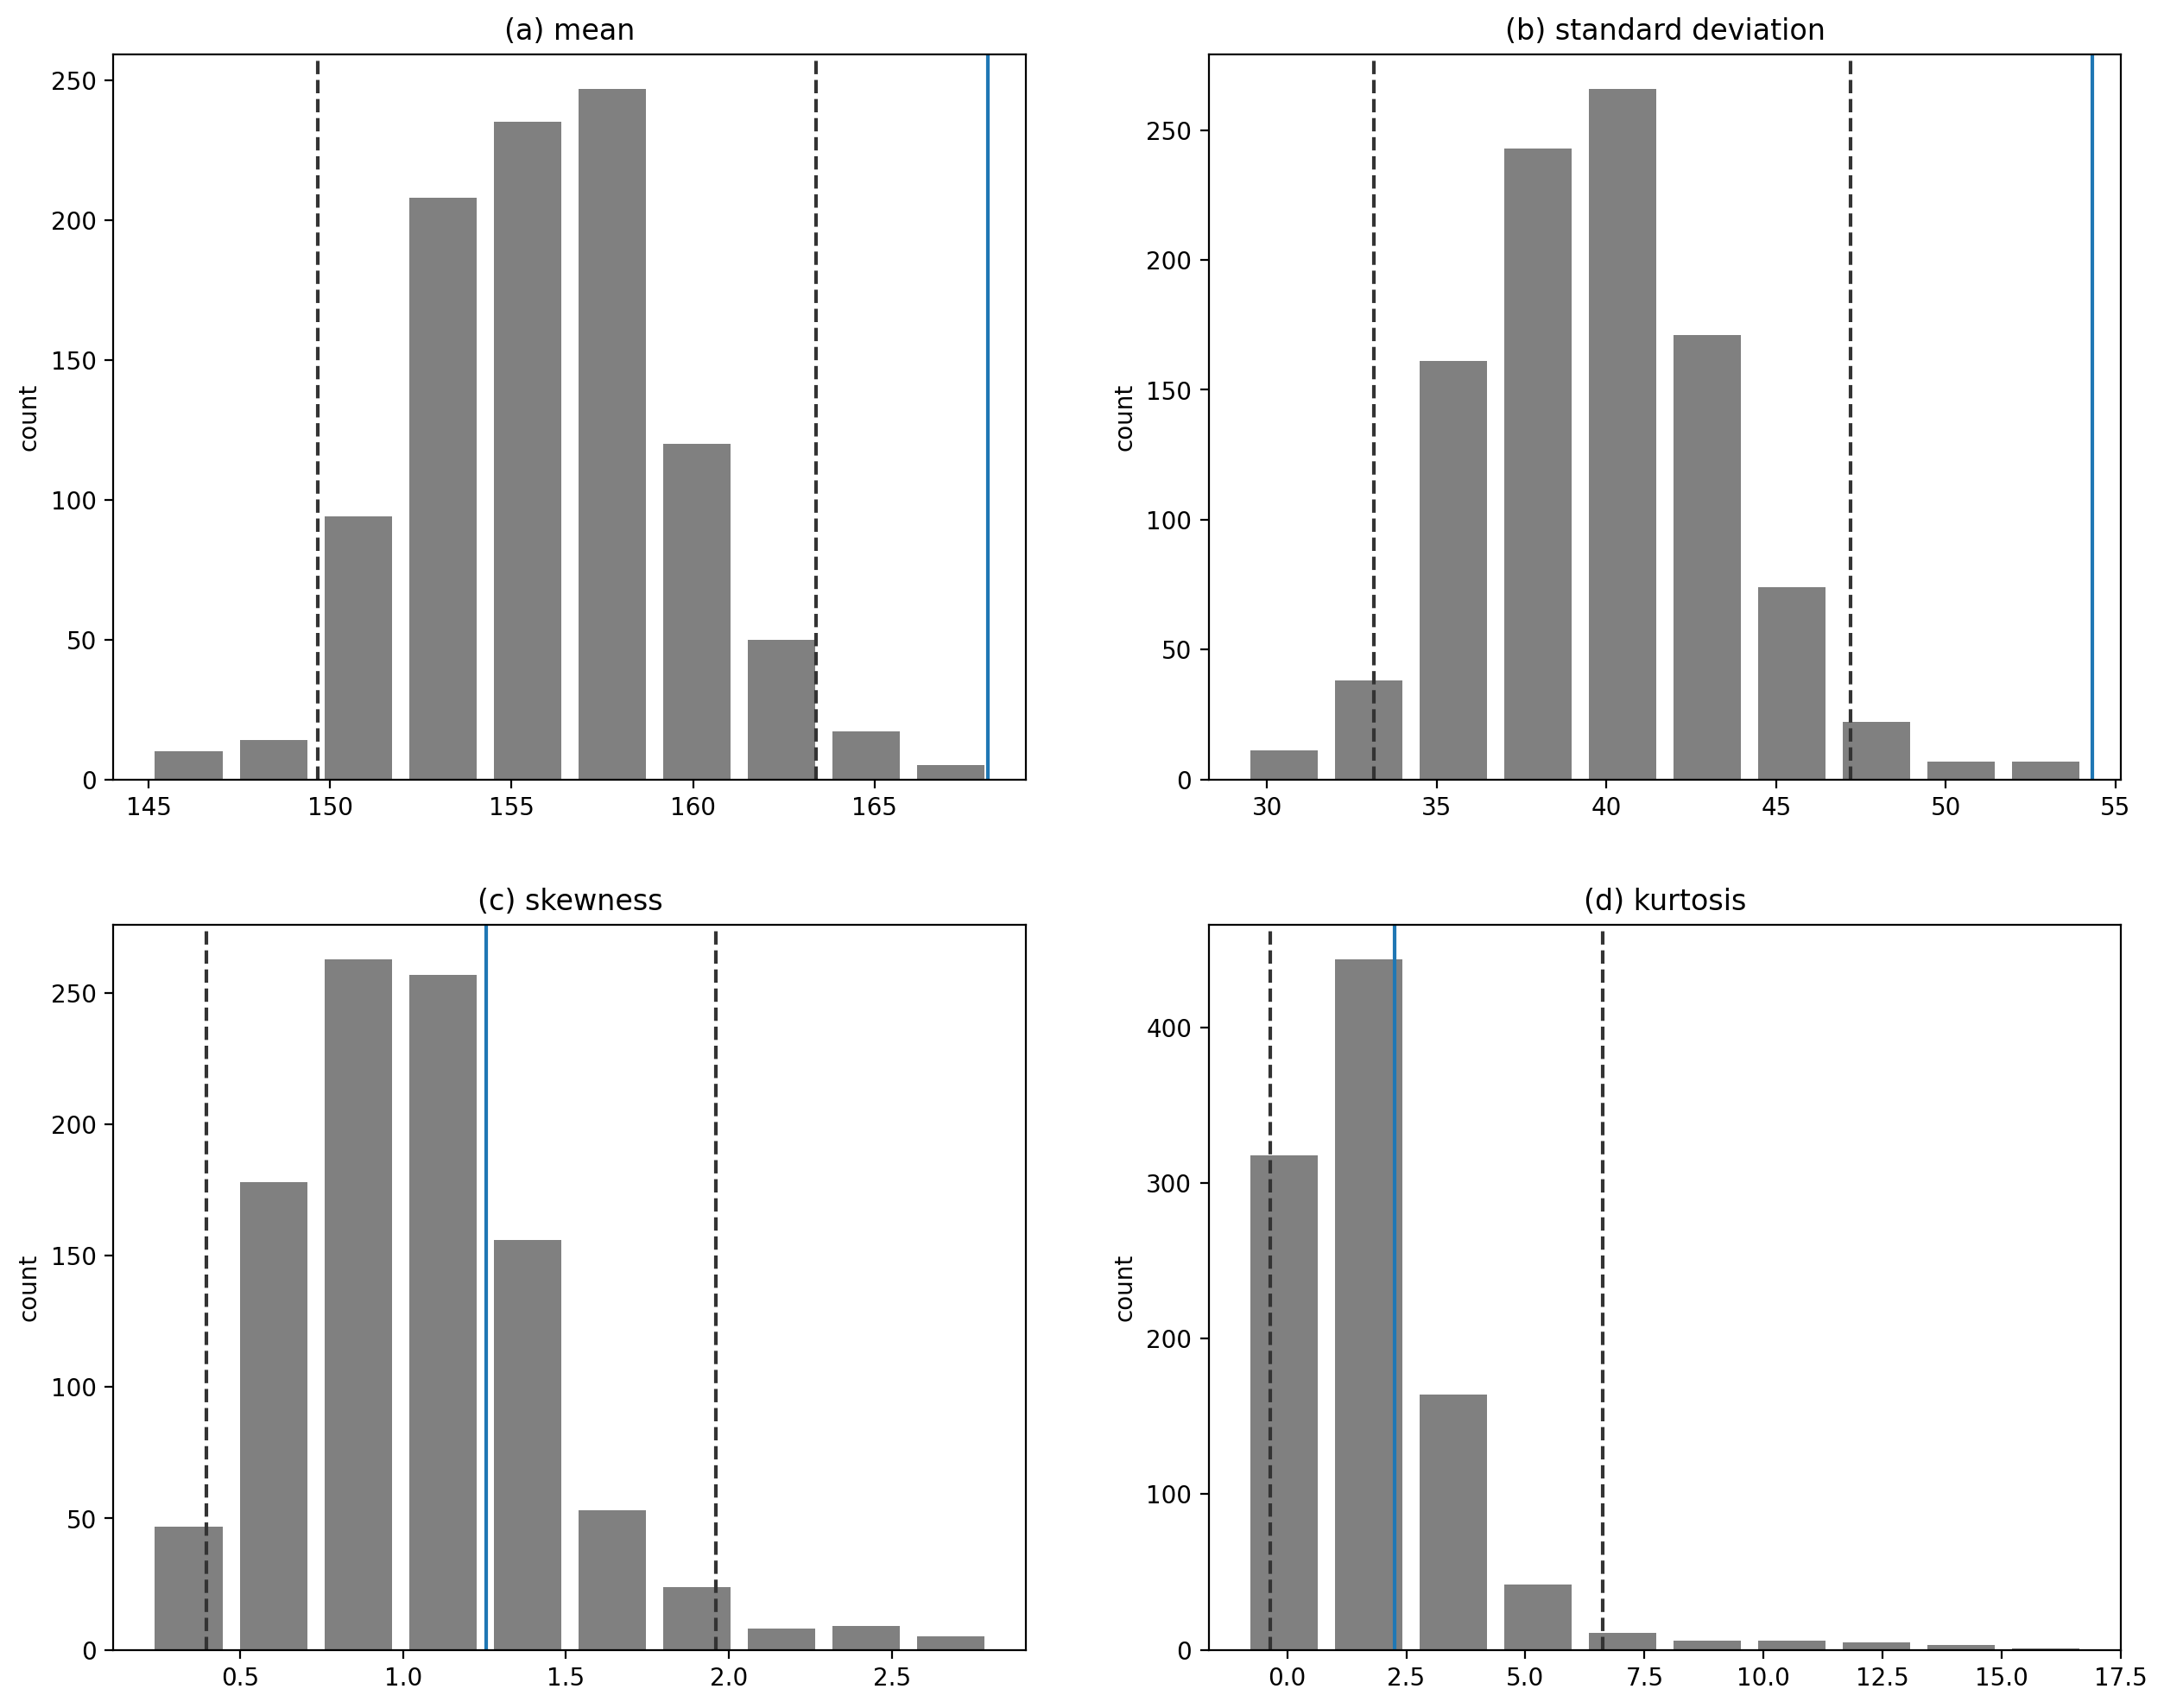

In [40]:
Image(filename=moments_raw_plot)

In [41]:
similarity_add_bias_ds = fileio.open_dataset(similarity_add_bc_file)

In [42]:
similarity_add_bias_ds['ks_statistic'].values

array(0.16365348, dtype=float32)

In [43]:
similarity_add_bias_ds['ks_pval'].values

array(0.07836358, dtype=float32)

In [44]:
similarity_add_bias_ds['ad_statistic'].values

array(1.9632941, dtype=float32)

In [45]:
similarity_add_bias_ds['ad_pval'].values

array(0.05043496, dtype=float32)

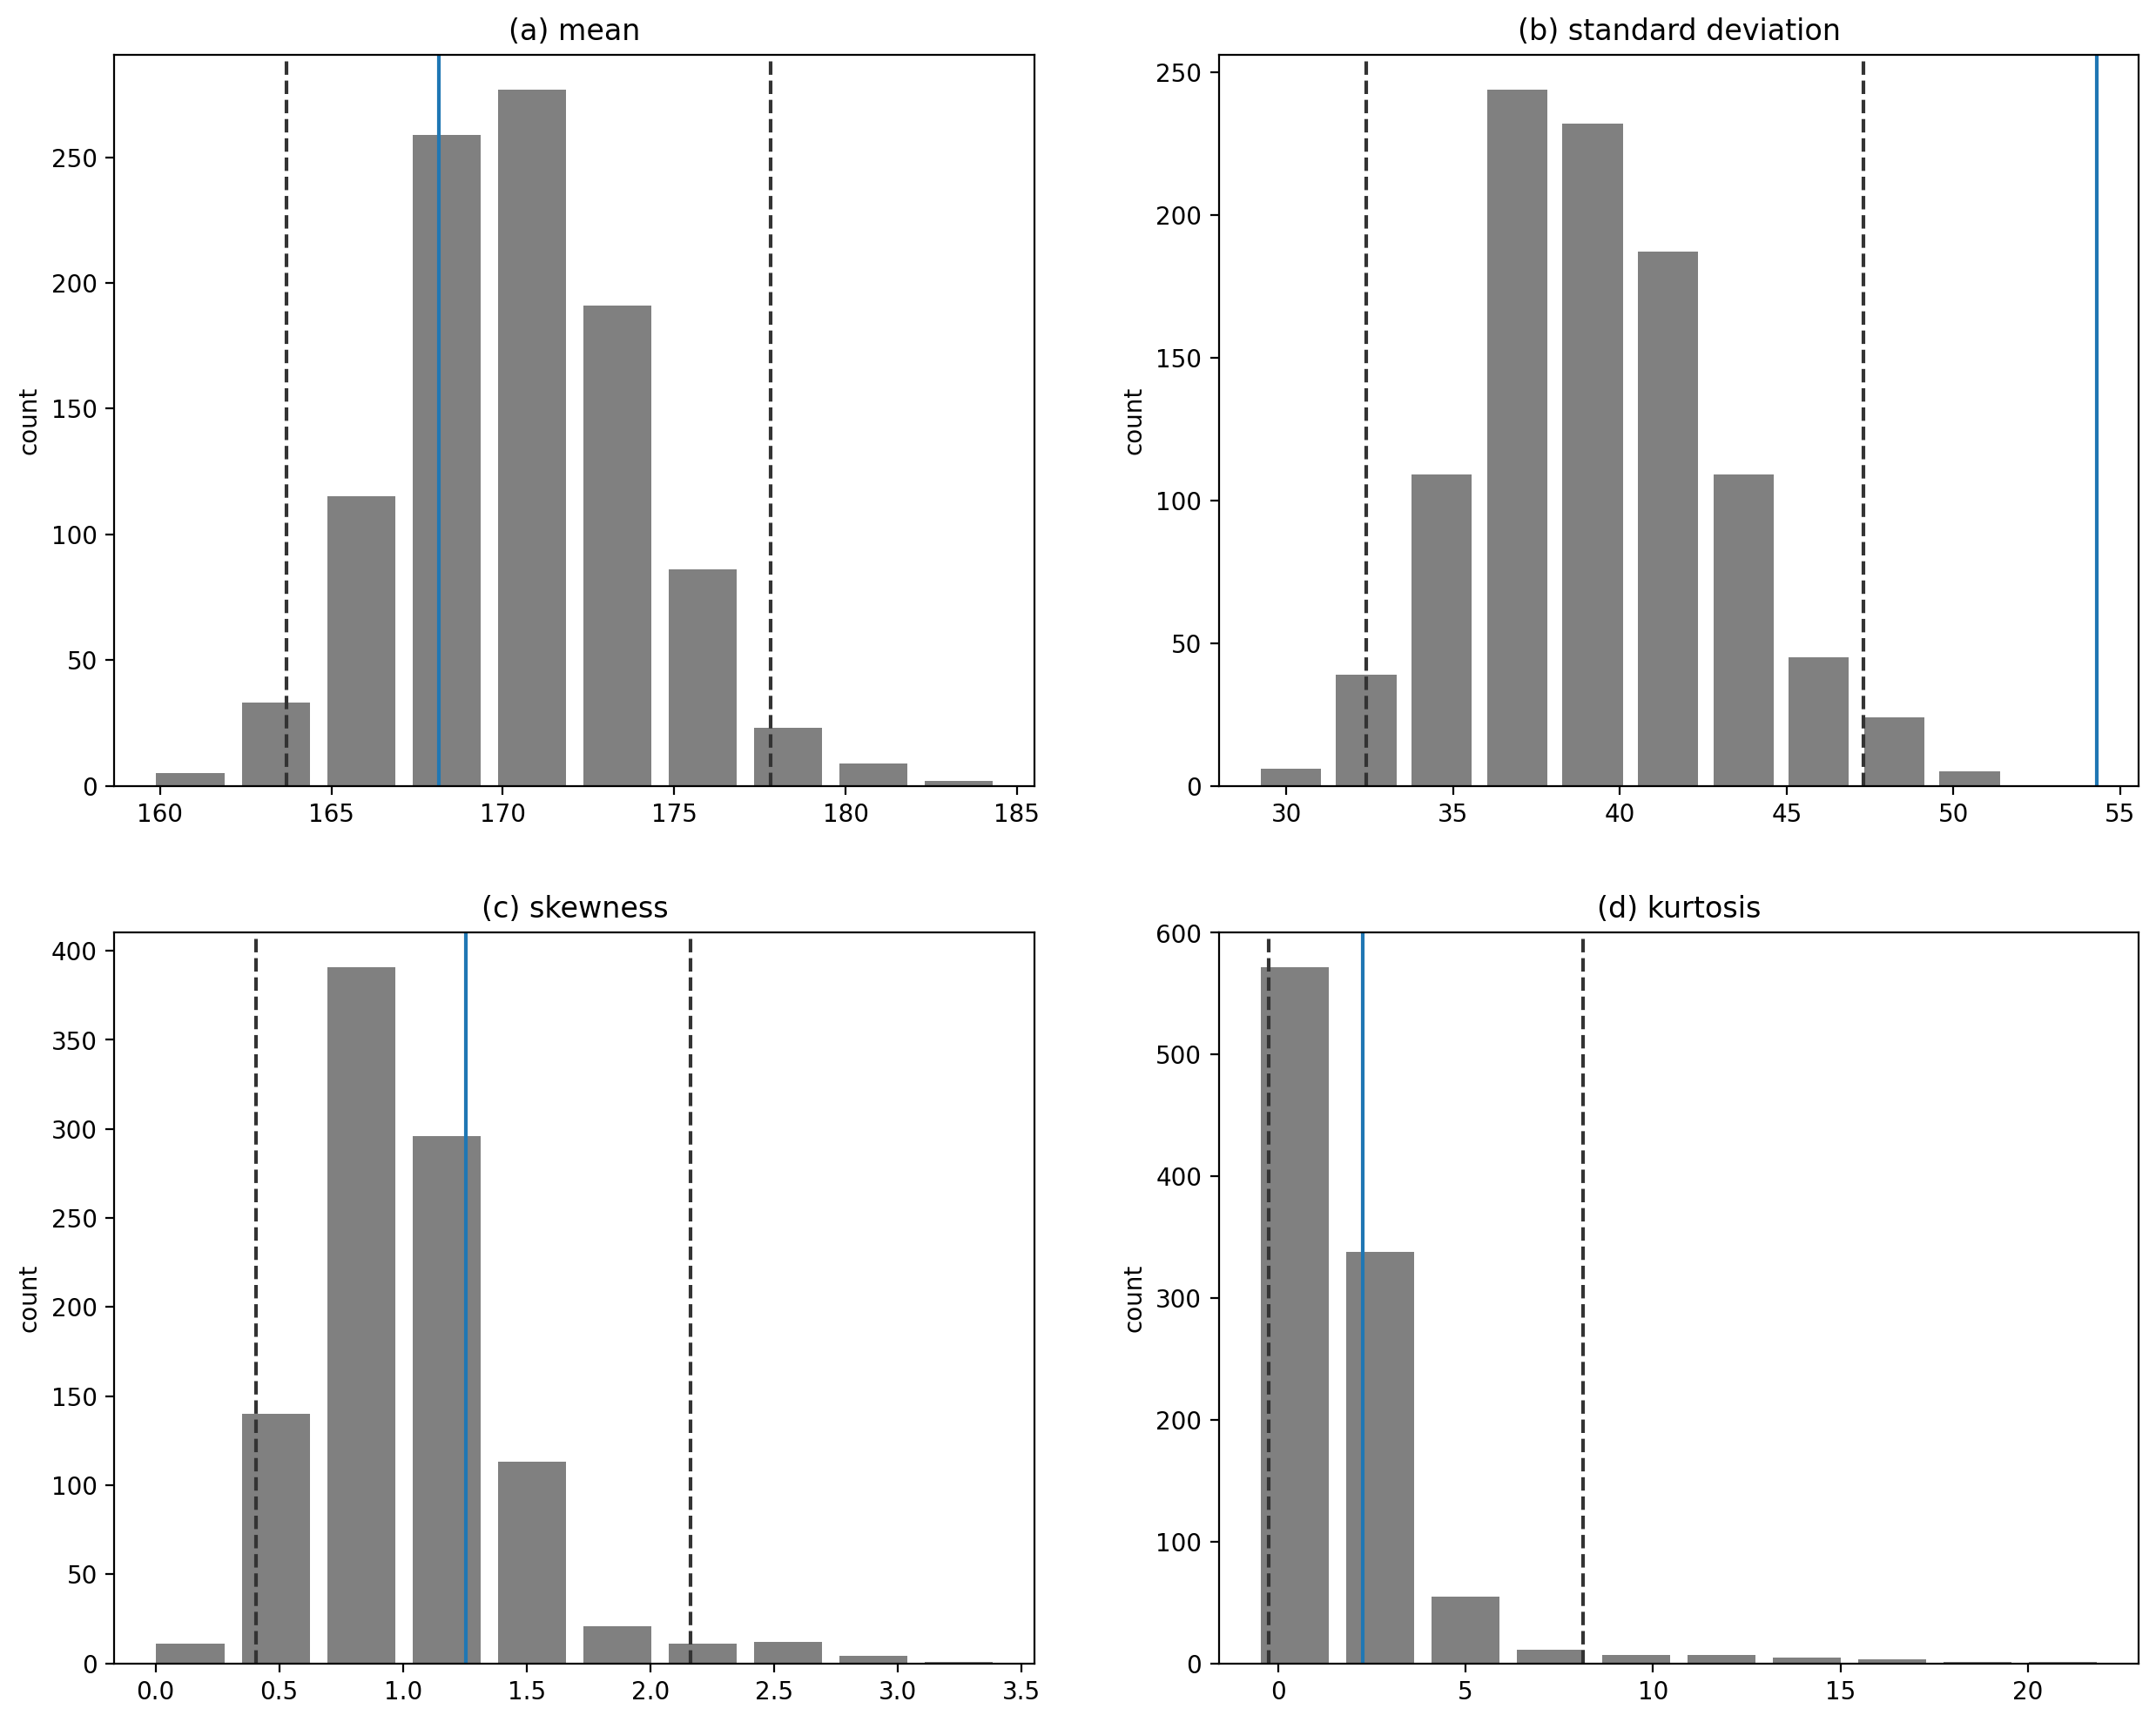

In [46]:
Image(filename=moments_add_plot)

In [47]:
similarity_mulc_bias_ds = fileio.open_dataset(similarity_mulc_bc_file)

In [48]:
similarity_mulc_bias_ds['ks_statistic'].values

array(0.14821093, dtype=float32)

In [49]:
similarity_mulc_bias_ds['ks_pval'].values

array(0.13940224, dtype=float32)

In [50]:
similarity_mulc_bias_ds['ad_statistic'].values

array(0.55864275, dtype=float32)

In [51]:
similarity_mulc_bias_ds['ad_pval'].values

array(0.19488814, dtype=float32)

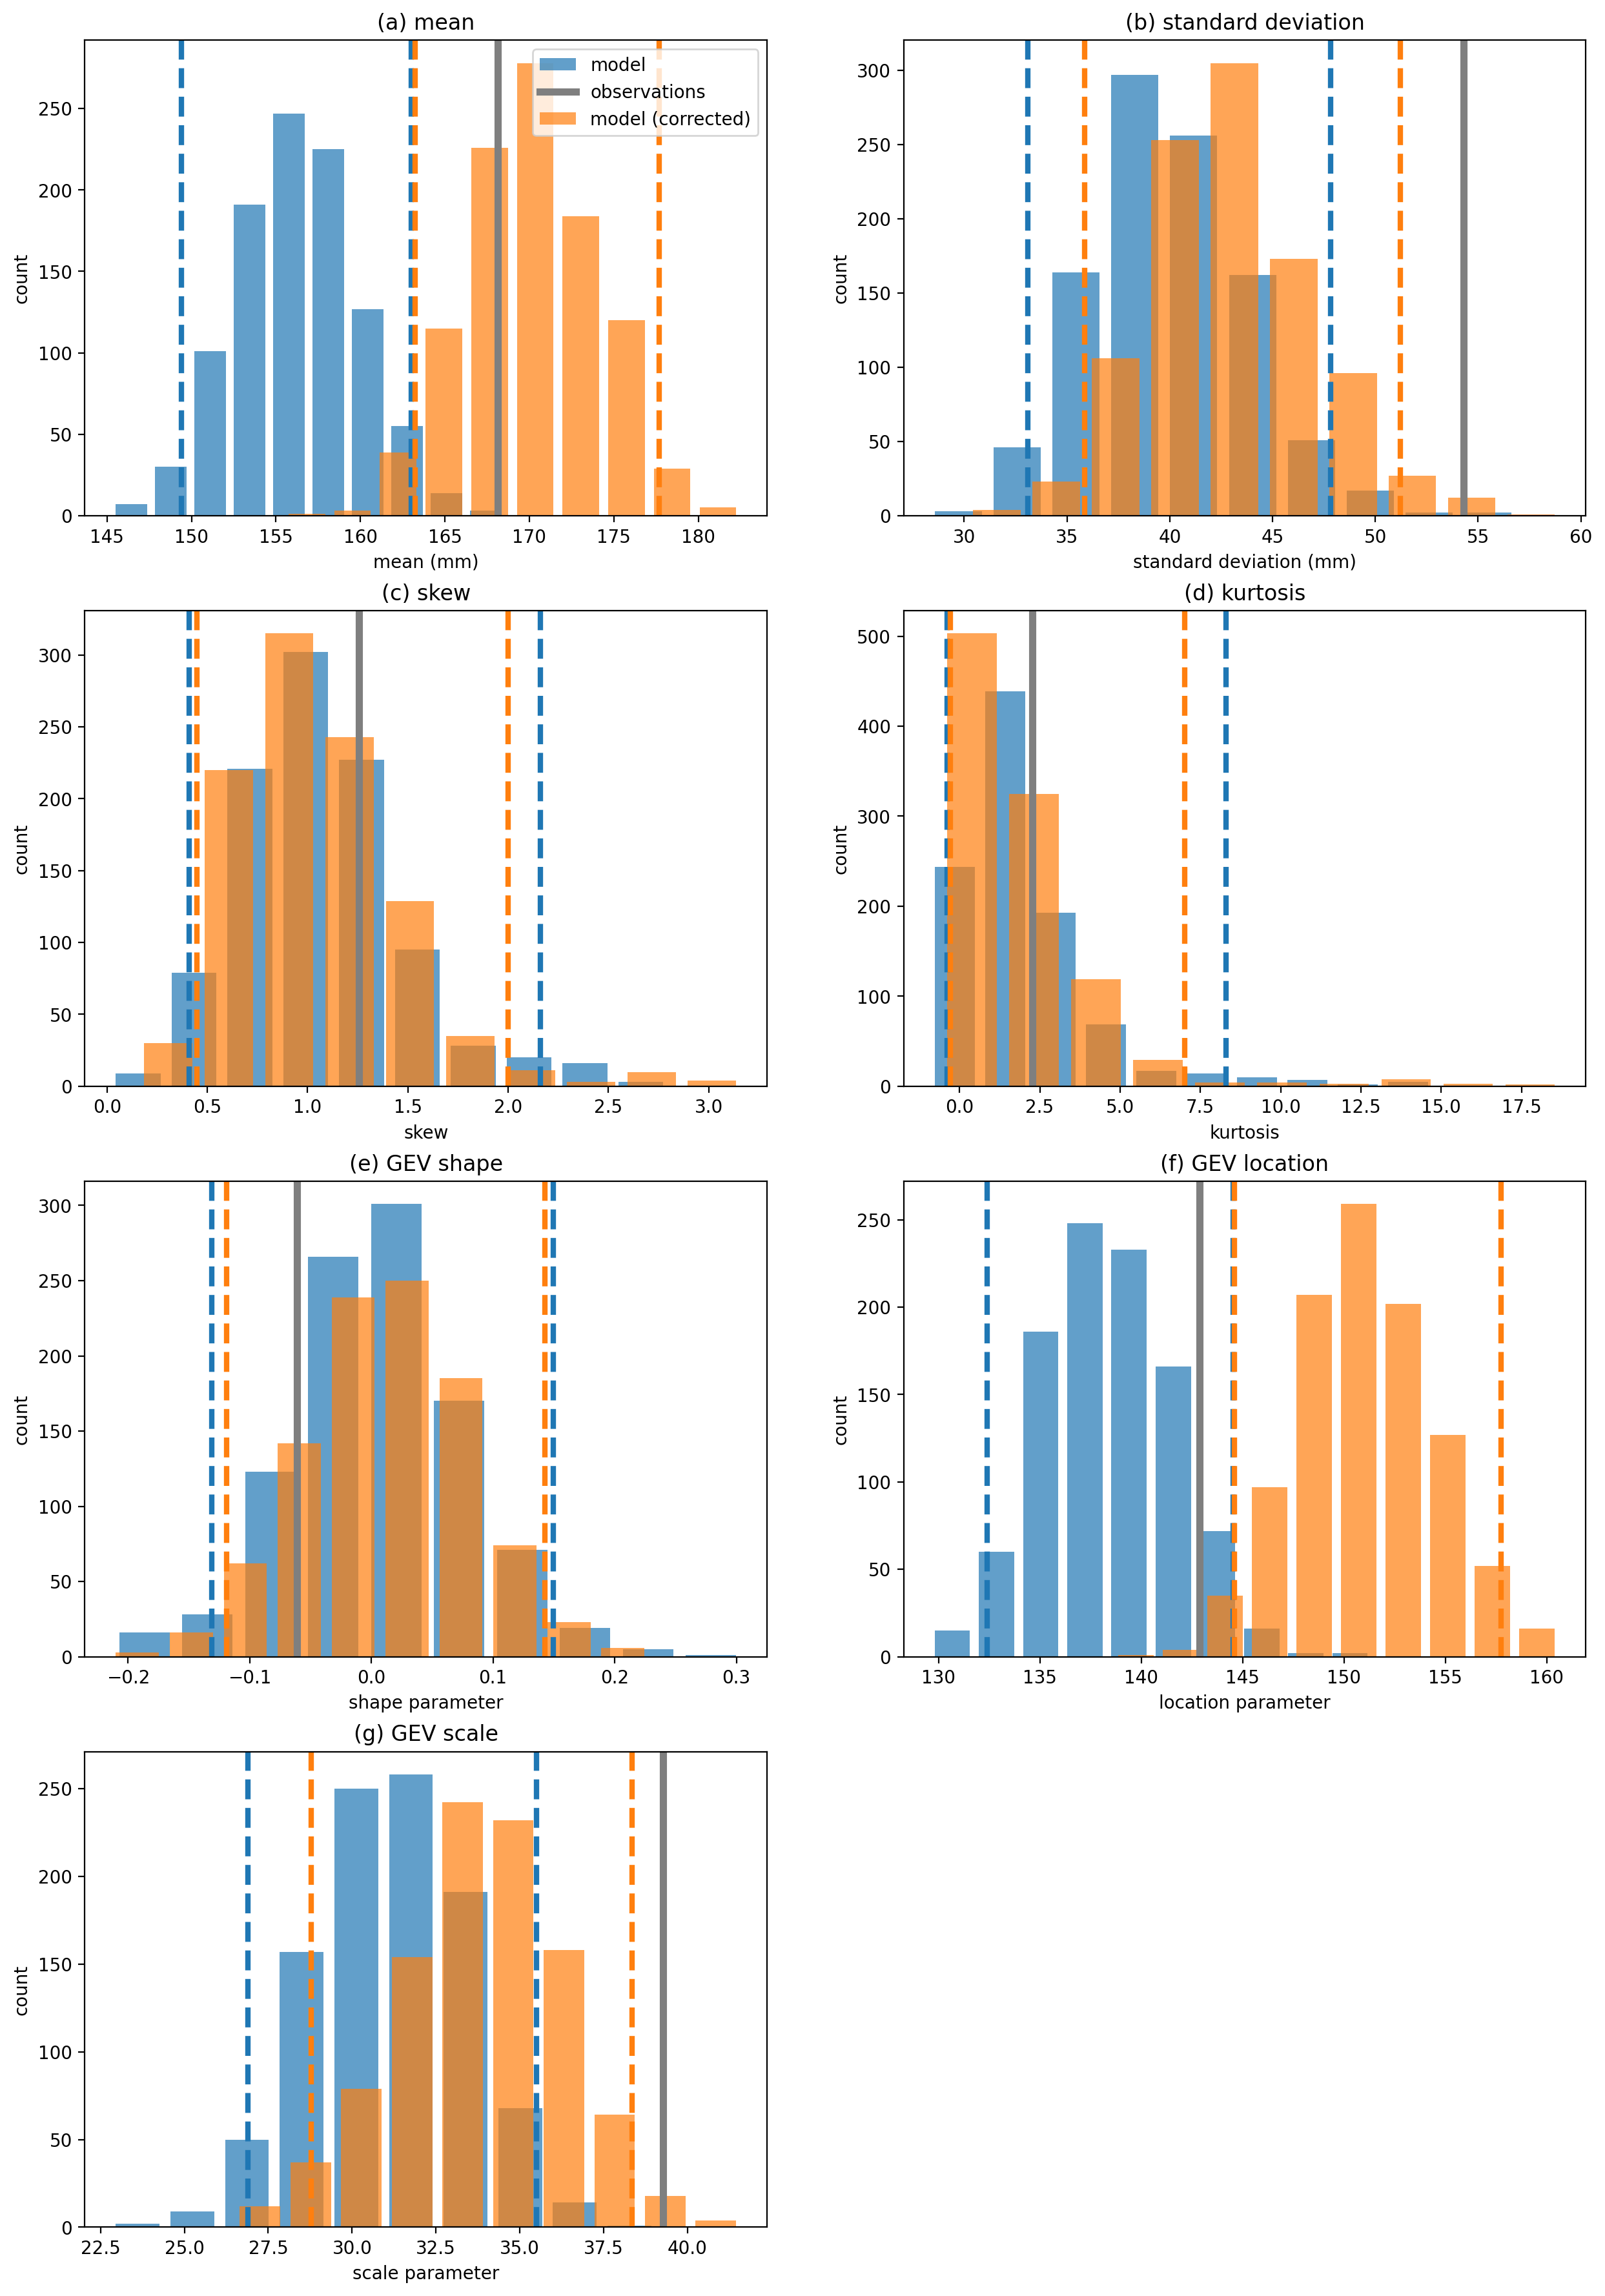

In [28]:
Image(filename=moments_mulc_plot)

### Return curves

In [46]:
def gev_event_likelihood(event, shape, loc, scale):
    """Get likelihood stats for an event from a GEV fit"""

    probability = gev.sf(event, shape, loc=loc, scale=scale)
    return_period = 1. / probability
    percentile = (1 - probability) * 100
    print(f'{percentile:.2f}% percentile')
    print(f'{return_period:.0f} year return period\n')

#### Additive bias corrected data

In [48]:
n_events_add_bc, n_population_add_bc, return_period_add_bc, percentile_add_bc = general_utils.event_in_context(model_add_bc_da_stacked.values, pr2022, 'above')
print('ADDITIVE BIAS CORRECTED DATA')
print(f'{n_events_add_bc} events in {n_population_add_bc} samples')
print(f'{percentile_add_bc:.2f}% percentile')
print(f'{return_period_add_bc:.0f} year return period')

ADDITIVE BIAS CORRECTED DATA
1 events in 5310 samples
99.98% percentile
5310 year return period


In [50]:
print('ADDITIVE BIAS CORRECTED GEV')
gev_event_likelihood(pr2022, model_add_bc_gev_shape, model_add_bc_gev_loc, model_add_bc_gev_scale)

ADDITIVE BIAS CORRECTED GEV
99.98% percentile
6178 year return period



#### Multiplicative bias corrected data

/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_return-curve_MIROC6.png


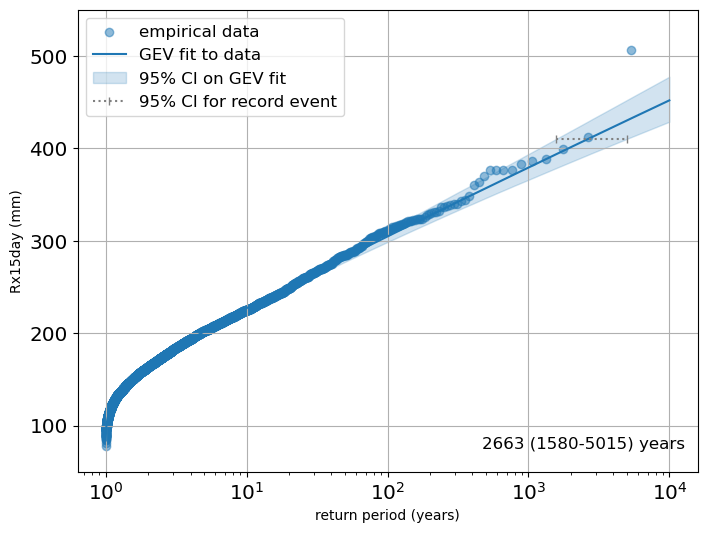

In [29]:
fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot()
general_utils.plot_gev_return_curve(
    ax,
    model_mulc_bc_da_stacked,
    pr2022,
    bootstrap_method='non-parametric',
    n_bootstraps=1000,
    ylabel='Rx15day (mm)',
    ylim=[50, 550],
    text=True,
)
outfile = f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_return-curve_{model_name}.png'
print(outfile)
plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
plt.show()

In [52]:
n_events_mulc_bc, n_population_mulc_bc, return_period_mulc_bc, percentile_mulc_bc = general_utils.event_in_context(model_add_bc_da_stacked.values, pr2022, 'above')
print('MULTIPLICATIVE BIAS CORRECTED DATA')
print(f'{n_events_mulc_bc} events in {n_population_mulc_bc} samples')
print(f'{percentile_mulc_bc:.2f}% percentile')
print(f'{return_period_mulc_bc:.0f} year return period')

MULTIPLICATIVE BIAS CORRECTED DATA
1 events in 5310 samples
99.98% percentile
5310 year return period


In [54]:
print('MULTIPLICATIVE BIAS CORRECTED GEV')
gev_event_likelihood(pr2022, model_mulc_bc_gev_shape, model_mulc_bc_gev_loc, model_mulc_bc_gev_scale)

MULTIPLICATIVE BIAS CORRECTED GEV
99.96% percentile
2663 year return period



#### Raw data

In [56]:
n_events, n_population, return_period, percentile = general_utils.event_in_context(model_da_stacked.values, pr2022, 'above')
print('RAW DATA')
print(f'{n_events} events in {n_population} samples')
print(f'{percentile:.2f}% percentile')
print(f'{return_period:.0f} year return period')

RAW DATA
1 events in 5310 samples
99.98% percentile
5310 year return period


In [58]:
print('RAW GEV')
gev_event_likelihood(pr2022, model_gev_shape, model_gev_loc, model_gev_scale)

RAW GEV
100.00% percentile
2099749 year return period



### Seasonality

In [29]:
model_df = model_da_stacked.to_dataframe()
model_df = model_df.dropna()

In [30]:
event_months = [int(date[5:7]) for date in model_df['event_time'].values]
event_years = [int(date[0:4]) for date in model_df['event_time'].values]

/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_timing_MIROC6_east-coast-flood-region.png


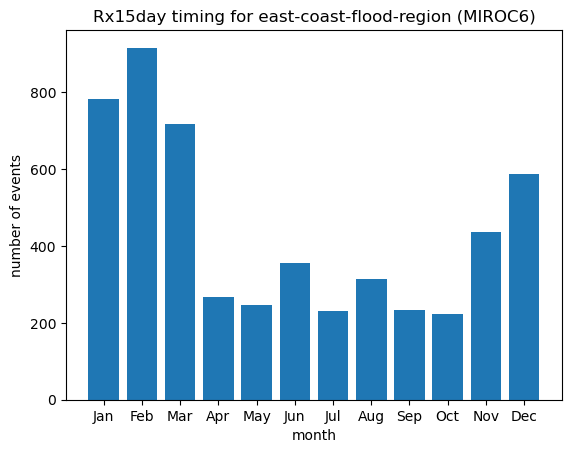

In [31]:
month_counts = Counter(event_months)
months = np.arange(1, 13)
counts = [month_counts[month] for month in months]

plt.bar(months, counts)
plt.title(f'Rx15day timing for {region_name} ({model_name})')
plt.ylabel('number of events')
plt.xlabel('month')
xlabels = [calendar.month_abbr[i] for i in months]
plt.xticks(months, xlabels)
outfile = f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_timing_{model_name}_{region_name}.png'
print(outfile)
plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
plt.show()

### Relationship with ENSO

In [56]:
nino_ds = fileio.open_dataset(nino_file)
nino_ds = nino_ds.assign_coords({'init_date': [date.strftime('%Y%m') for date in nino_ds['init_date'].values]})
nino_ds

<xarray.Dataset>
Dimensions:    (init_date: 59, ensemble: 10, lead_time: 122)
Coordinates:
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 7 ... 115 116 117 118 119 120 121
  * ensemble   (ensemble) int64 0 1 2 3 4 5 6 7 8 9
  * init_date  (init_date) <U6 '196011' '196111' '196211' ... '201711' '201811'
    time       (lead_time, init_date) object dask.array<chunksize=(122, 59), meta=np.ndarray>
Data variables:
    tos        (init_date, ensemble, lead_time) float32 dask.array<chunksize=(59, 10, 122), meta=np.ndarray>
Attributes:
    history:  Fri Mar 03 12:33:25 2023: /g/data/xv83/dbi599/miniconda3/envs/u...

In [57]:
nino_values = []
for index, row in model_df.iterrows():
    event_init_date = row['init_date'].strftime('%Y%m')
    event_ensemble = row['ensemble']
    event_year_month = row['time'].strftime('%Y-%m')
    nino_selection = nino_ds.sel({'init_date': event_init_date, 'ensemble': event_ensemble})
    nino_selection = nino_selection.swap_dims({'lead_time': 'time'})
    nino_year_month = [date.strftime('%Y-%m') for date in nino_selection['time'].values]
    nino_selection = nino_selection.assign_coords({'time': nino_year_month})
    nino_value = float(nino_selection['tos'].sel({'time': event_year_month}).values)
    nino_values.append(nino_value)

In [58]:
model_df['nino34'] = nino_values

/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_ENSO_MIROC6_east-coast-flood-region.png


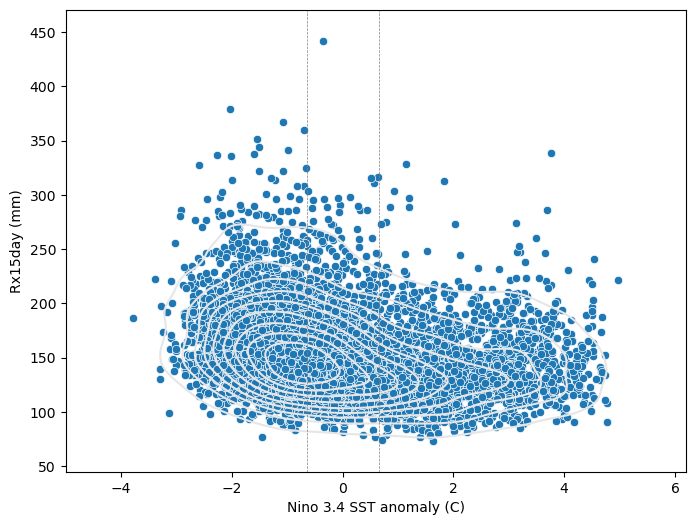

In [59]:
fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(111)

sns.scatterplot(ax=ax, data=model_df, x='nino34', y='pr')
sns.kdeplot(ax=ax, data=model_df, x='nino34', y='pr', color='0.9', linewidth=1)

ax.set_ylabel('Rx15day (mm)')
ax.set_xlabel('Nino 3.4 SST anomaly (C)')
ax.axvline(0.65, color='0.5', linestyle='--', linewidth=0.5)
ax.axvline(-0.65, color='0.5', linestyle='--', linewidth=0.5)
outfile = f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_ENSO_{model_name}_{region_name}.png'
print(outfile)
plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
plt.show()

### Meteorology

In [56]:
def plot_average(start_date, end_date, color_da=None, color_var=None, contour_da=None, contour_var=None):
    """Plot average"""
    
    fig = plt.figure(figsize=[10, 5])
    map_proj=ccrs.PlateCarree(central_longitude=180)
    ax1 = fig.add_subplot(1, 1, 1, projection=map_proj)       
    
    if color_var:
        if color_var == 'pr':
            levels = [0, 100, 200, 300, 400, 500, 600, 700, 800]
            label = 'total precipitation (mm)'
            cmap = cmocean.cm.rain
            extend = 'max'
        elif color_var == 'ua300':
            levels = [-30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30]
            label = '300hPa zonal wind'
            cmap='RdBu_r'
            extend = 'both'
        else:
            raise ValueError('Invalid color variable')
        color_da.plot(
            ax=ax1,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            levels=levels,
            extend=extend,
            cbar_kwargs={'label': label},
        )
    
    if contour_var:
        if contour_var == 'z500':
            levels = np.arange(5000, 6300, 50)
        elif contour_var == 'psl':
            levels = np.arange(900, 1100, 2.5)
        elif contour_var == 'ua300':
            levels = np.arange(15, 60, 5)
        else:
            raise ValueError('Invalid contour variable')
        lines = contour_da.plot.contour(
            ax=ax1,
            transform=ccrs.PlateCarree(),
            levels=levels,
            colors=['0.1']
        )
        ax1.clabel(lines, colors=['0.1'], manual=False, inline=True)
    
    ax1.coastlines()
    ax1.set_extent([90, 205, -55, 10], crs=ccrs.PlateCarree())
    ax1.gridlines(linestyle='--', draw_labels=True)
    if contour_var:
        ax1.set_title(f'Average {contour_var} ({contour_da.units}), {start_date} to {end_date}')
    else:
        ax1.set_title(f'{start_date} to {end_date}')
#    plt.savefig(
#        f'/home/599/dbi599/east-coast-rain/{color_var}-{contour_var}_mean_BARRA2_{start_date}_{end_date}.png',
#        bbox_inches='tight',
#        facecolor='white',
#        dpi=300
#    )
    plt.show()

In [32]:
ranked_events = model_df.sort_values(by=['pr'], ascending=False)
ranked_events.head(n=10)

event_time                 time  \
ensemble init_date           lead_time                                    
3        1978-11-01 00:00:00 2          1981-02-27  1980-11-01 12:00:00   
6        2003-11-01 00:00:00 6          2010-02-19  2009-10-31 12:00:00   
5        1993-11-01 00:00:00 6          2000-03-09  1999-11-02 12:00:00   
2        1979-11-01 00:00:00 9          1989-02-12  1988-10-31 12:00:00   
8        1993-11-01 00:00:00 1          1995-02-12  1994-11-01 12:00:00   
5        1969-11-01 00:00:00 4          1974-02-19  1973-11-01 12:00:00   
2        1986-11-01 00:00:00 9          1996-02-01  1995-11-02 12:00:00   
7        1995-11-01 00:00:00 7          2003-01-30  2002-10-31 12:00:00   
         2018-11-01 00:00:00 3          2022-02-20  2021-11-01 12:00:00   
1        1972-11-01 00:00:00 2          1975-02-12  1974-11-01 12:00:00   

                                        ensemble            init_date  \
ensemble init_date           lead_time                                  
3        1978-11-01 00:00:00 2                 3  1978-11-01 00:00:00   
6        2003-11-01 00:00:00 6                 6  2003-11-01 00:00:00   
5        1993-11-01 00:00:00 6                 5  1993-11-01 00:00:00   
2        1979-11-01 00:00:00 9                 2  1979-11-01 00:00:00   
8        1993-11-01 00:00:00 1                 8  1993-11-01 00:00:00   
5        1969-11-01 00:00:00 4                 5  1969-11-01 00:00:00   
2        1986-11-01 00:00:00 9                 2  1986-11-01 00:00:00   
7        1995-11-01 00:00:00 7                 7  1995-11-01 00:00:00   
         2018-11-01 00:00:00 3                 7  2018-11-01 00:00:00   
1        1972-11-01 00:00:00 2                 1  1972-11-01 00:00:00   

                                        lead_time          pr  
ensemble init_date           lead_time                         
3        1978-11-01 00:00:00 2                  2  441.878570  
6        2003-11-01 00:00:00 6                  6  379.469096  
5        1993-11-01 00:00:00 6                  6  367.190542  
2        1979-11-01 00:00:00 9                  9  359.518069  
8        1993-11-01 00:00:00 1                  1  351.493236  
5        1969-11-01 00:00:00 4                  4  343.960658  
2        1986-11-01 00:00:00 9                  9  341.199184  
7        1995-11-01 00:00:00 7                  7  338.257125  
         2018-11-01 00:00:00 3                  3  337.571486  
1        1972-11-01 00:00:00 2                  2  336.359287

In [33]:
model_add_bc_df = model_add_bc_ds['pr'].to_dataframe()
model_add_bc_df = model_add_bc_df.dropna()
model_add_bc_df = model_add_bc_df.reset_index()
ranked_add_bc_events = model_add_bc_df.sort_values(by=['pr'], ascending=False)
ranked_add_bc_events.head(n=10)

init_date  ensemble  lead_time  event_time  \
1648  1978-11-01 00:00:00         3          2  1981-02-27   
3929  2003-11-01 00:00:00         6          6  2010-02-19   
3020  1993-11-01 00:00:00         5          6  2000-03-09   
1736  1979-11-01 00:00:00         2          9  1989-02-12   
3042  1993-11-01 00:00:00         8          1  1995-02-12   
3219  1995-11-01 00:00:00         7          7  2003-01-30   
1090  1972-11-01 00:00:00         1          2  1975-02-12   
5285  2018-11-01 00:00:00         7          3  2022-02-20   
1114  1972-11-01 00:00:00         3          8  1981-01-30   
2366  1986-11-01 00:00:00         2          9  1996-02-01   

                     time          pr  
1648  1980-11-01 12:00:00  463.848622  
3929  2009-10-31 12:00:00  393.264306  
3020  1999-11-02 12:00:00  380.985751  
1736  1988-10-31 12:00:00  369.977121  
3042  1994-11-01 12:00:00  363.066932  
3219  2002-10-31 12:00:00  360.320402  
1090  1974-11-01 12:00:00  358.329339  
5285  2021-11-01 12:00:00  355.282697  
1114  1980-11-01 12:00:00  352.036523  
2366  1995-11-02 12:00:00  351.658236

In [34]:
model_mulc_bc_df = model_mulc_bc_ds['pr'].to_dataframe()
model_mulc_bc_df = model_mulc_bc_df.dropna()
model_mulc_bc_df = model_mulc_bc_df.reset_index()
ranked_mulc_bc_events = model_mulc_bc_df.sort_values(by=['pr'], ascending=False)
ranked_mulc_bc_events.head(n=10)

init_date  ensemble  lead_time  event_time  \
1648  1978-11-01 00:00:00         3          2  1981-02-27   
3929  2003-11-01 00:00:00         6          6  2010-02-19   
3020  1993-11-01 00:00:00         5          6  2000-03-09   
3219  1995-11-01 00:00:00         7          7  2003-01-30   
1090  1972-11-01 00:00:00         1          2  1975-02-12   
1736  1979-11-01 00:00:00         2          9  1989-02-12   
3042  1993-11-01 00:00:00         8          1  1995-02-12   
2886  1992-11-01 00:00:00         0          7  2000-02-02   
5285  2018-11-01 00:00:00         7          3  2022-02-20   
2395  1986-11-01 00:00:00         6          2  1988-12-25   

                     time          pr  
1648  1980-11-01 12:00:00  507.056680  
3929  2009-10-31 12:00:00  412.872142  
3020  1999-11-02 12:00:00  399.512758  
3219  2002-10-31 12:00:00  388.274150  
1090  1974-11-01 12:00:00  385.973058  
1736  1988-10-31 12:00:00  383.323074  
3042  1994-11-01 12:00:00  377.100975  
2886  1999-11-02 12:00:00  376.914728  
5285  2021-11-01 12:00:00  376.640430  
2395  1988-11-01 12:00:00  376.146173

1978 (1981-02-27), ensemble: r4, 441.87857042739955mm


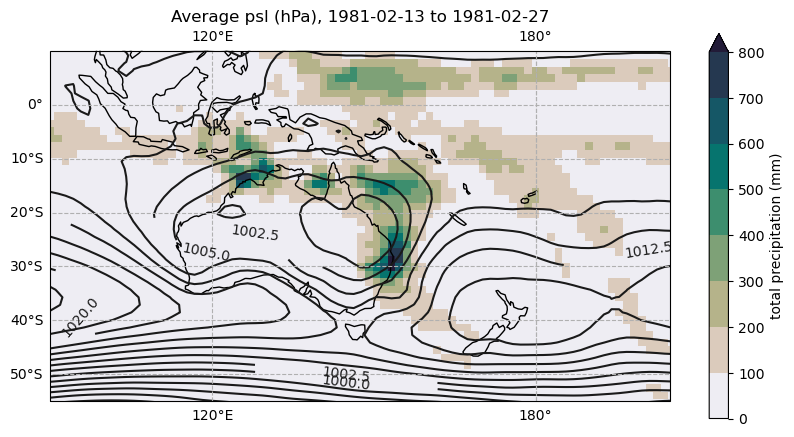

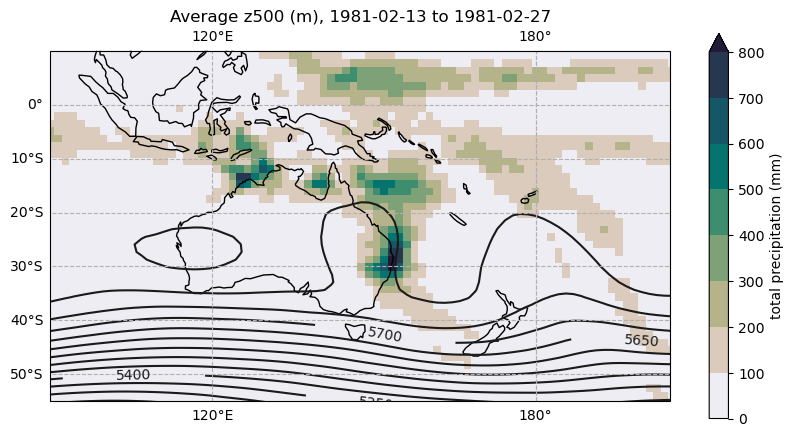

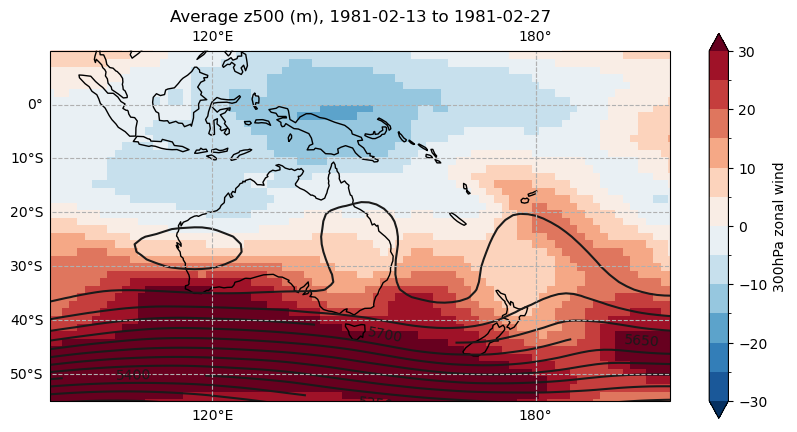

2003 (2010-02-19), ensemble: r7, 379.4690964942481mm


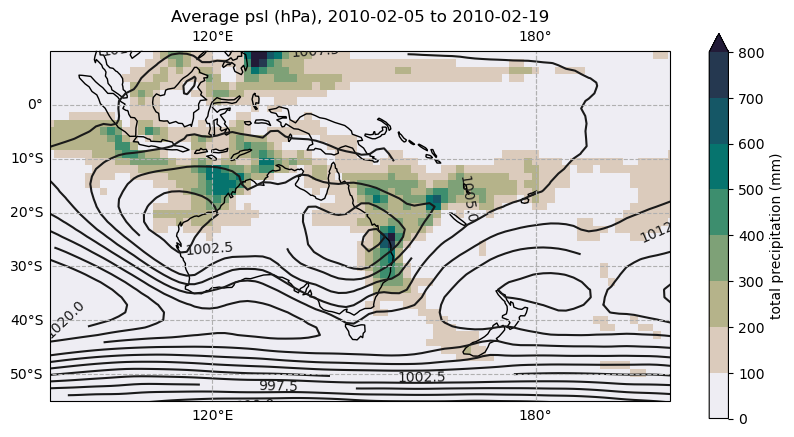

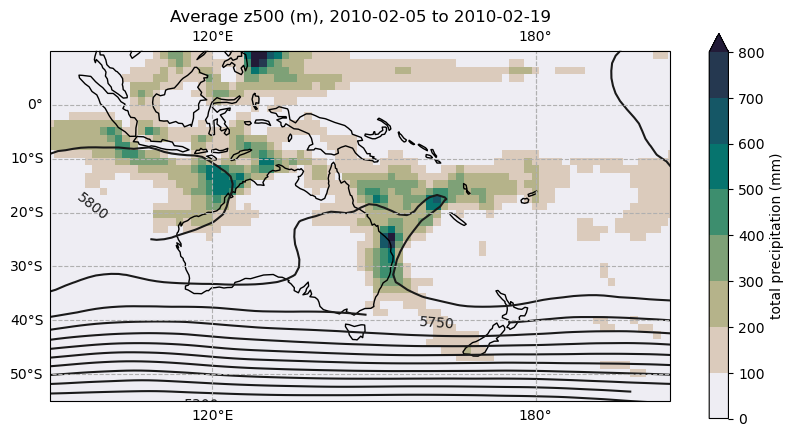

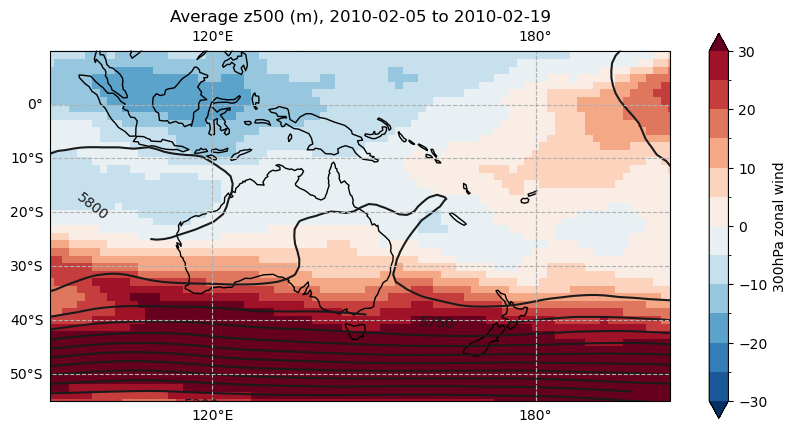

1993 (2000-03-09), ensemble: r6, 367.1905418908925mm


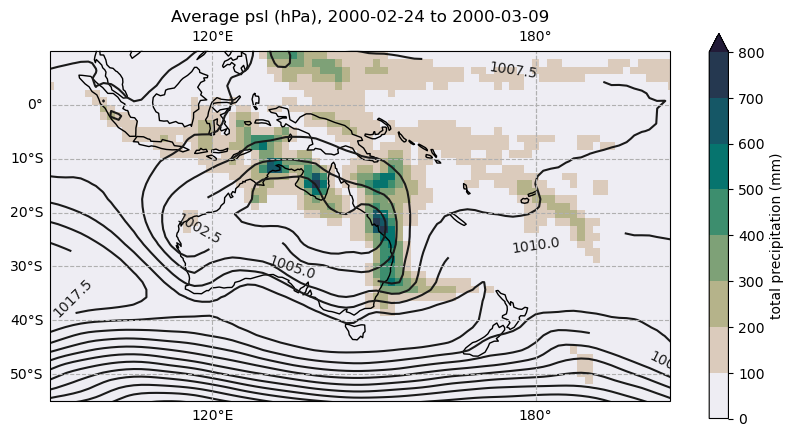

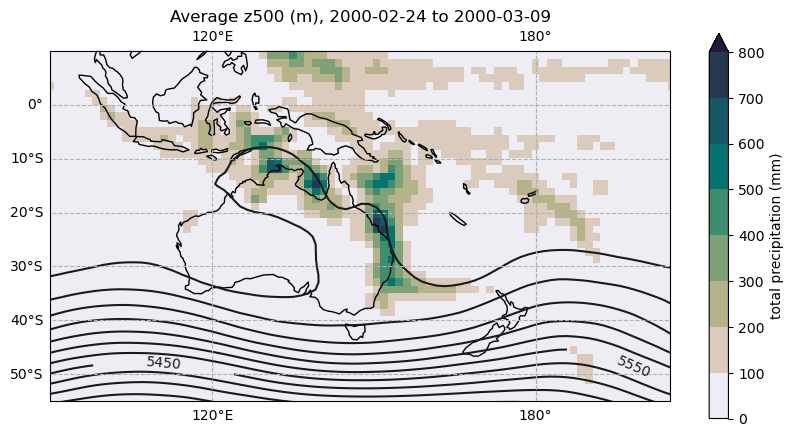

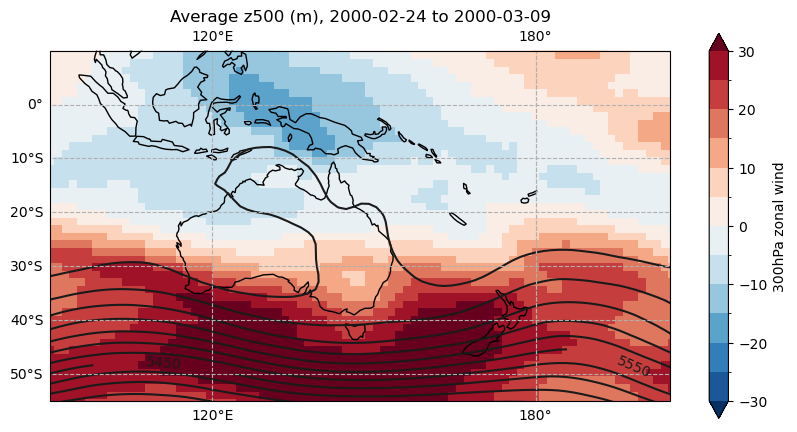

1979 (1989-02-12), ensemble: r3, 359.5180694165594mm


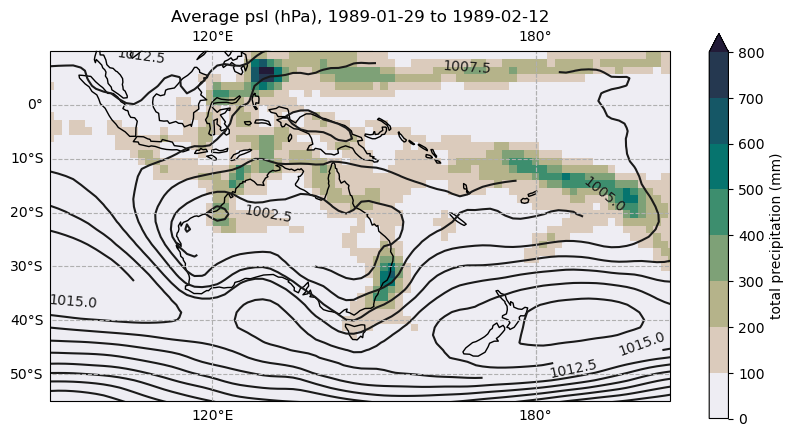

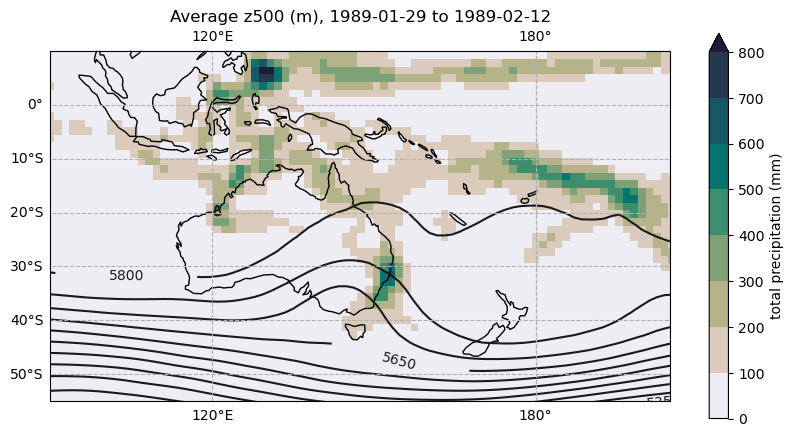

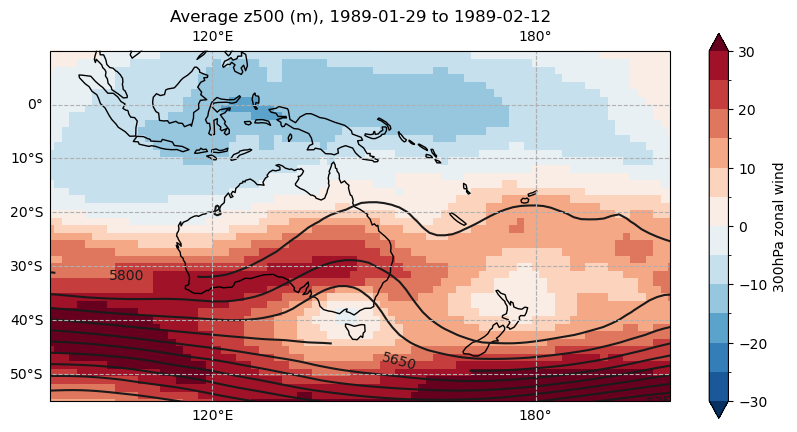

In [60]:
for index, row in ranked_events.head(n=4).iterrows():
    init_date = int(row['init_date'].strftime('%Y'))
    ensemble = int(row['ensemble']) + 1
    end_date = row['event_time']
    rx_value = row['pr']
    print(f'{init_date} ({end_date}), ensemble: r{ensemble}, {rx_value}mm')
    
    start_datetime = datetime.datetime.strptime(end_date, "%Y-%m-%d") - datetime.timedelta(days=14)
    start_date = start_datetime.strftime("%Y-%m-%d")
    
    pr_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/*/{model_name}/dcppA-hindcast/s{init_date}-r{ensemble}i1p1f1/day/pr/*/*/*.nc')
    pr_files.sort()
    ds_pr = fileio.open_dataset(pr_files, variables=['pr'],)
    
    psl_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/*/{model_name}/dcppA-hindcast/s{init_date}-r{ensemble}i1p1f1/day/psl/*/*/*.nc')
    psl_files.sort()
    ds_psl = fileio.open_dataset(psl_files, variables=['psl'],)
    
    zg_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/*/{model_name}/dcppA-hindcast/s{init_date}-r{ensemble}i1p1f1/day/zg/*/*/*.nc')
    zg_files.sort()
    ds_zg = fileio.open_dataset(zg_files, variables=['zg'],)
    
    ua_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/*/{model_name}/dcppA-hindcast/s{init_date}-r{ensemble}i1p1f1/day/ua/*/*/*.nc')
    ua_files.sort()
    ds_ua = fileio.open_dataset(ua_files, variables=['ua'],)

    pr_da = ds_pr.sel({'time': slice(start_date, end_date)})['pr']
    pr_da = xc.units.convert_units_to(pr_da, 'mm d-1')
    psl_da = ds_psl.sel({'time': slice(start_date, end_date)})['psl']
    psl_da = xc.units.convert_units_to(psl_da, 'hPa')
    zg_da = ds_zg.sel({'time': slice(start_date, end_date)})['zg']
    z500_da = zg_da.sel({'plev': 50000}, method='nearest')
    ua_da = ds_ua.sel({'time': slice(start_date, end_date)})['ua']
    ua300_da = ua_da.sel({'plev': 30000}, method='nearest')

    pr_da_sum = pr_da.sum('time', keep_attrs=True)
    psl_da_mean = psl_da.mean('time', keep_attrs=True)
    z500_da_mean = z500_da.mean('time', keep_attrs=True)
    ua300_da_mean = ua300_da.mean('time', keep_attrs=True) 

    plot_average(start_date, end_date, pr_da_sum, 'pr', psl_da_mean, 'psl')
    plot_average(start_date, end_date, pr_da_sum, 'pr', z500_da_mean, 'z500')
    plot_average(start_date, end_date, ua300_da_mean, 'ua300', z500_da_mean, 'z500')

In [35]:
def plot_mslp(ax, title, pr_da, mslp_da):
    """Plot MSLP"""

    pr_da.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmocean.cm.rain,
        levels=[0, 100, 200, 300, 400, 500, 600, 700, 800, 900],
        extend='max',
        cbar_kwargs={'label': 'total precipitation (mm)'},
    )
    lines = mslp_da.plot.contour(
        ax=ax,
        transform=ccrs.PlateCarree(),
        levels=np.arange(900, 1100, 2.5),
        colors=['0.1']
    )
    ax.clabel(lines, colors=['0.1'], manual=False, inline=True)
    
    ax.coastlines()
    ax.set_extent([95, 195, -55, -5], crs=ccrs.PlateCarree())
    ax.gridlines(linestyle='--', draw_labels=True)
    ax.set_title(title)

/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_top3_mslp-pr_MIROC6.png


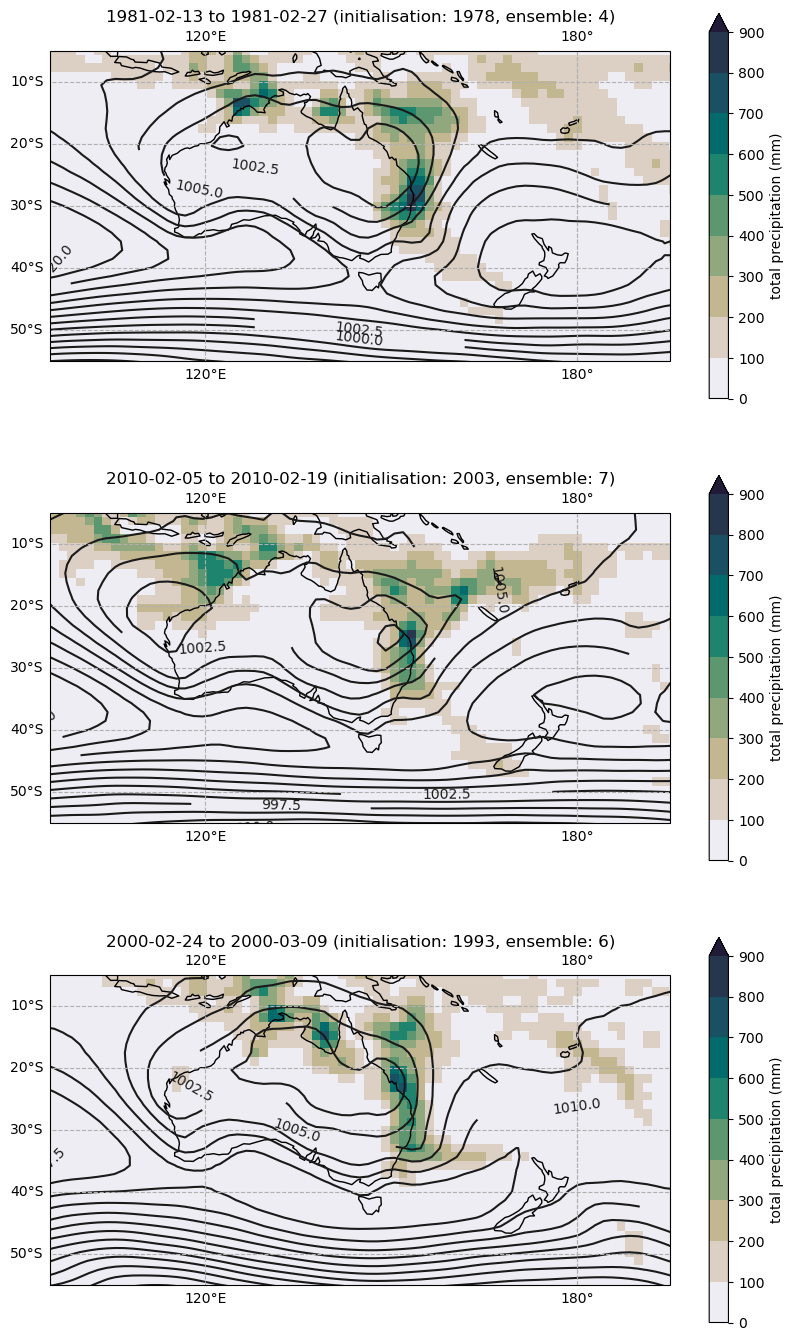

In [33]:
fig = plt.figure(figsize=[10, 17])
map_proj=ccrs.PlateCarree(central_longitude=180)

plotnum = 1
for index, row in ranked_events.head(n=3).iterrows():
    ax = fig.add_subplot(3, 1, plotnum, projection=map_proj)
    
    init_date = int(row['init_date'].strftime('%Y'))
    ensemble = int(row['ensemble']) + 1
    end_date = row['event_time']

    start_datetime = datetime.datetime.strptime(end_date, "%Y-%m-%d") - datetime.timedelta(days=14)
    start_date = start_datetime.strftime("%Y-%m-%d")
    title = f'{start_date} to {end_date} (initialisation: {init_date}, ensemble: {ensemble})'
    
    pr_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/*/{model_name}/dcppA-hindcast/s{init_date}-r{ensemble}i1p1f1/day/pr/*/*/*.nc')
    pr_files.sort()
    ds_pr = fileio.open_dataset(pr_files, variables=['pr'],)
    
    psl_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/*/{model_name}/dcppA-hindcast/s{init_date}-r{ensemble}i1p1f1/day/psl/*/*/*.nc')
    psl_files.sort()
    ds_psl = fileio.open_dataset(psl_files, variables=['psl'],)
    
    pr_da = ds_pr.sel({'time': slice(start_date, end_date)})['pr']
    pr_da = xc.units.convert_units_to(pr_da, 'mm d-1')
    psl_da = ds_psl.sel({'time': slice(start_date, end_date)})['psl']
    psl_da = xc.units.convert_units_to(psl_da, 'hPa')

    pr_da_sum = pr_da.sum('time', keep_attrs=True)
    psl_da_mean = psl_da.mean('time', keep_attrs=True)
    
    plot_mslp(ax, title, pr_da_sum, psl_da_mean)
    plotnum += 1

outfile = f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_top3_mslp-pr_{model_name}.png'
print(outfile)
plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
plt.show()

/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_top1_mslp-pr_MIROC6.png


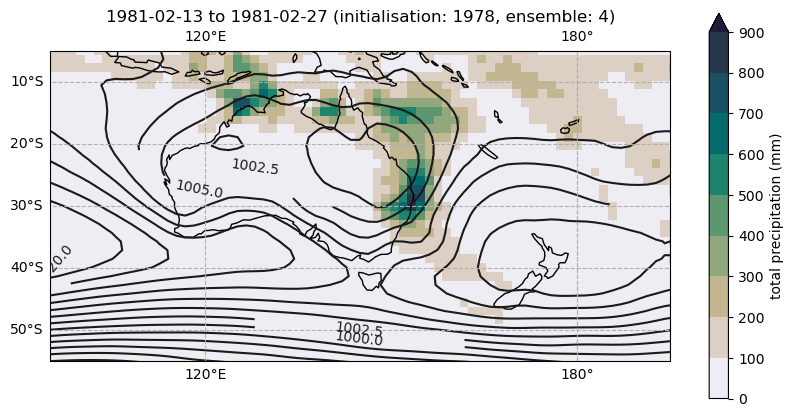

In [36]:
fig = plt.figure(figsize=[10, 5])
map_proj=ccrs.PlateCarree(central_longitude=180)

plotnum = 1
for index, row in ranked_events.head(n=1).iterrows():
    ax = fig.add_subplot(1, 1, plotnum, projection=map_proj)
    
    init_date = int(row['init_date'].strftime('%Y'))
    ensemble = int(row['ensemble']) + 1
    end_date = row['event_time']

    start_datetime = datetime.datetime.strptime(end_date, "%Y-%m-%d") - datetime.timedelta(days=14)
    start_date = start_datetime.strftime("%Y-%m-%d")
    title = f'{start_date} to {end_date} (initialisation: {init_date}, ensemble: {ensemble})'
    
    pr_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/*/{model_name}/dcppA-hindcast/s{init_date}-r{ensemble}i1p1f1/day/pr/*/*/*.nc')
    pr_files.sort()
    ds_pr = fileio.open_dataset(pr_files, variables=['pr'],)
    
    psl_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/*/{model_name}/dcppA-hindcast/s{init_date}-r{ensemble}i1p1f1/day/psl/*/*/*.nc')
    psl_files.sort()
    ds_psl = fileio.open_dataset(psl_files, variables=['psl'],)
    
    pr_da = ds_pr.sel({'time': slice(start_date, end_date)})['pr']
    pr_da = xc.units.convert_units_to(pr_da, 'mm d-1')
    psl_da = ds_psl.sel({'time': slice(start_date, end_date)})['psl']
    psl_da = xc.units.convert_units_to(psl_da, 'hPa')

    pr_da_sum = pr_da.sum('time', keep_attrs=True)
    psl_da_mean = psl_da.mean('time', keep_attrs=True)
    
    plot_mslp(ax, title, pr_da_sum, psl_da_mean)
    plotnum += 1

outfile = f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_top1_mslp-pr_{model_name}.png'
print(outfile)
plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
plt.show()